In [ ]:
import os
import json
import numpy as np

def load_json(json_path):
    with open(json_path, "r") as file:
        data = json.load(file)
    return data

def save_json(data, output_path):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, "w") as file:
        json.dump(data, file, indent=4)
    print(f"✅ Saved: {output_path}")

def json_to_numpy(json_data):
    keypoints = []
    for frame in json_data:
        frame_data = []
        for key in frame["pose"]:
            frame_data.append(frame["pose"][key])
        keypoints.append(frame_data)
    return np.array(keypoints)  # (T, 33, 3)

def numpy_to_json(numpy_data, original_json):
    new_json = []
    for i, frame in enumerate(original_json):
        new_frame = {
            "frame": frame["frame"],
            "name": frame["name"],
            "pose": {}
        }
        for j, key in enumerate(frame["pose"].keys()):
            new_frame["pose"][key] = numpy_data[i][j].tolist()
        new_json.append(new_frame)
    return new_json


In [2]:
def jittering_json(json_data, noise_level=0.01):
    skeleton = json_to_numpy(json_data)
    noise = np.random.normal(loc=0, scale=noise_level, size=skeleton.shape)
    return numpy_to_json(skeleton + noise, json_data)

def scaling_json(json_data, scale_range=(0.9, 1.1)):
    skeleton = json_to_numpy(json_data)
    scale_factor = np.random.uniform(scale_range[0], scale_range[1])
    return numpy_to_json(skeleton * scale_factor, json_data)

def rotation_json(json_data, angle_range=(-15, 15)):
    skeleton = json_to_numpy(json_data)
    angle = np.radians(np.random.uniform(angle_range[0], angle_range[1]))
    cos_val, sin_val = np.cos(angle), np.sin(angle)
    rotation_matrix = np.array([[cos_val, -sin_val], [sin_val, cos_val]])
    skeleton[:, :, :2] = np.dot(skeleton[:, :, :2] - np.mean(skeleton[:, :, :2], axis=0), rotation_matrix) + np.mean(skeleton[:, :, :2], axis=0)
    return numpy_to_json(skeleton, json_data)

def horizontal_flip_json(json_data):
    skeleton = json_to_numpy(json_data)
    skeleton[:, :, 0] = 1 - skeleton[:, :, 0]
    return numpy_to_json(skeleton, json_data)

def temporal_warping_json(json_data, warp_factor_range=(0.8, 1.2)):
    skeleton = json_to_numpy(json_data)
    warp_factor = np.random.uniform(warp_factor_range[0], warp_factor_range[1])
    num_frames = int(skeleton.shape[0] * warp_factor)
    indices = np.linspace(0, skeleton.shape[0] - 1, num_frames, dtype=int)
    return numpy_to_json(skeleton[indices], json_data[:len(skeleton[indices])])

def time_masking_json(json_data, mask_ratio=0.2):
    skeleton = json_to_numpy(json_data)
    T = skeleton.shape[0]
    num_mask = int(T * mask_ratio)
    mask_indices = np.random.choice(T, num_mask, replace=False)
    skeleton[mask_indices] = 0
    return numpy_to_json(skeleton, json_data)

def frame_interpolation_json(json_data):
    skeleton = json_to_numpy(json_data)
    T, V, C = skeleton.shape
    new_T = T * 2 - 1
    interpolated_skeleton = np.zeros((new_T, V, C))

    for i in range(T - 1):
        interpolated_skeleton[2 * i] = skeleton[i]
        interpolated_skeleton[2 * i + 1] = (skeleton[i] + skeleton[i + 1]) / 2
    
    interpolated_skeleton[-1] = skeleton[-1]
    return numpy_to_json(interpolated_skeleton, json_data[:new_T])

In [3]:
def apply_augmentation_to_folder(input_folder, output_base_folder, augmentation_fn, aug_name):
    """
    Chạy một augmentation trên toàn bộ thư mục JSON và lưu vào thư mục mới.
    
    input_folder: Thư mục chứa dữ liệu gốc (vd: "data/keypoints/Garland_Pose")
    output_base_folder: Thư mục gốc để lưu dữ liệu augment
    augmentation_fn: Hàm augmentation cần áp dụng
    aug_name: Tên augmentation (dùng đặt tên folder)
    """
    output_folder = os.path.join(output_base_folder, f"keypoints_augmented_{aug_name}", os.path.basename(input_folder))

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file in os.listdir(input_folder):
        if file.endswith(".json"):
            input_path = os.path.join(input_folder, file)
            output_path = os.path.join(output_folder, file)

            json_data = load_json(input_path)

            augmented_json = augmentation_fn(json_data)

            save_json(augmented_json, output_path)

In [ ]:
def run_all_augmentations(input_folder, output_base_folder):
    augmentations = {
        "jittering": jittering_json,
        "scaling": scaling_json,
        "rotation": rotation_json,
        "horizontal_flip": horizontal_flip_json,
        "temporal_warping": temporal_warping_json,
        "time_masking": time_masking_json,
        "frame_interpolation": frame_interpolation_json,
    }

    for aug_name, aug_fn in augmentations.items():
        print(f"\n Processing: {aug_name}...")
        apply_augmentation_to_folder(input_folder, output_base_folder, aug_fn, aug_name)

In [5]:
input_folder = "data/keypoints/Garland_Pose"
output_base_folder = "data"

run_all_augmentations(input_folder, output_base_folder)


🚀 Đang chạy augmentation: jittering...
✅ Saved: data\keypoints_augmented_jittering\Garland_Pose\sample1.json
✅ Saved: data\keypoints_augmented_jittering\Garland_Pose\sample10.json
✅ Saved: data\keypoints_augmented_jittering\Garland_Pose\sample11.json
✅ Saved: data\keypoints_augmented_jittering\Garland_Pose\sample12.json
✅ Saved: data\keypoints_augmented_jittering\Garland_Pose\sample13.json
✅ Saved: data\keypoints_augmented_jittering\Garland_Pose\sample14.json
✅ Saved: data\keypoints_augmented_jittering\Garland_Pose\sample15.json
✅ Saved: data\keypoints_augmented_jittering\Garland_Pose\sample16.json
✅ Saved: data\keypoints_augmented_jittering\Garland_Pose\sample17.json
✅ Saved: data\keypoints_augmented_jittering\Garland_Pose\sample18.json
✅ Saved: data\keypoints_augmented_jittering\Garland_Pose\sample19.json
✅ Saved: data\keypoints_augmented_jittering\Garland_Pose\sample2.json
✅ Saved: data\keypoints_augmented_jittering\Garland_Pose\sample20.json
✅ Saved: data\keypoints_augmented_jitte

#### SO SÁNH DATA GỐC VÀ SAU KHI AUGMENTED

In [31]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def load_json(json_path):
    """ Đọc dữ liệu keypoints từ file JSON """
    with open(json_path, "r") as file:
        return json.load(file)

def json_to_numpy(json_data):
    """ Chuyển đổi keypoints từ JSON thành numpy array (T, 33, 3) """
    keypoints = []
    for frame in json_data:
        frame_data = []
        for key in frame["pose"]:
            frame_data.append(frame["pose"][key])
        keypoints.append(frame_data)
    return np.array(keypoints)  # (T, 33, 3)

def visualize_keypoints_with_diff(original_json_path, augmented_json_path):
    """
    Vẽ biểu đồ so sánh tọa độ keypoints trước và sau augmentation + In sự khác biệt theo X, Y, và khoảng cách Euclidean.
    """
    original_json = load_json(original_json_path)
    augmented_json = load_json(augmented_json_path)

    original_data = json_to_numpy(original_json)
    augmented_data = json_to_numpy(augmented_json)

    # Lấy frame đầu tiên để vẽ
    original_frame = original_data[0]
    augmented_frame = augmented_data[0]

    # Tọa độ x, y của keypoints
    original_x, original_y = original_frame[:, 0], original_frame[:, 1]
    augmented_x, augmented_y = augmented_frame[:, 0], augmented_frame[:, 1]

    # Tính sai lệch trên trục X, Y và Khoảng cách Euclidean
    diff_x = np.abs(original_x - augmented_x)
    diff_y = np.abs(original_y - augmented_y)
    diff_distance = np.sqrt((original_x - augmented_x) ** 2 + (original_y - augmented_y) ** 2)

    # Vẽ scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(original_x, original_y, c='blue', label='Original', alpha=0.7)
    plt.scatter(augmented_x, augmented_y, c='red', label='Augmented', alpha=0.7, marker='x')

    # Vẽ đường nối giữa original và augmented
    for i in range(len(original_x)):
        plt.plot([original_x[i], augmented_x[i]], [original_y[i], augmented_y[i]], 'gray', linestyle="--", alpha=0.5)

        # Hiển thị giá trị sự khác biệt ngay trên hình vẽ
        plt.text((original_x[i] + augmented_x[i]) / 2, (original_y[i] + augmented_y[i]) / 2,
                 f"{diff_distance[i]:.4f}", fontsize=8, color='black')

    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title(f"So sánh keypoints (Khoảng cách Euclidean): {os.path.basename(original_json_path)}")
    plt.legend()
    plt.gca().invert_yaxis()  # Lật trục Y để khớp với góc nhìn camera
    plt.show()

    # In ra sự khác biệt chi tiết từng keypoint
    print(f"\n Sự khác biệt giữa {original_json_path} vs {augmented_json_path}")
    print(f"{'Keypoint':<20} {'X Diff':<15} {'Y Diff':<15} {'Distance'}")
    print("-" * 60)
    for i, key in enumerate(original_json[0]["pose"].keys()):
        print(f"{key:<20} {diff_x[i]:<15.5f} {diff_y[i]:<15.5f} {diff_distance[i]:.5f}")

def visualize_folder(original_folder, augmented_folder):
    """
    Chạy visualize + In sự khác biệt cho tất cả file JSON trong thư mục.
    """
    original_files = sorted([f for f in os.listdir(original_folder) if f.endswith(".json")])
    augmented_files = sorted([f for f in os.listdir(augmented_folder) if f.endswith(".json")])

    for file in original_files:
        original_path = os.path.join(original_folder, file)
        augmented_path = os.path.join(augmented_folder, file)

        if file in augmented_files:
            print(f"\n🚀 Visualizing {file} ...")
            visualize_keypoints_with_diff(original_path, augmented_path)
        else:
            print(f"Không tìm thấy file {file} trong thư mục Augmented!")


🚀 Visualizing sample1.json ...


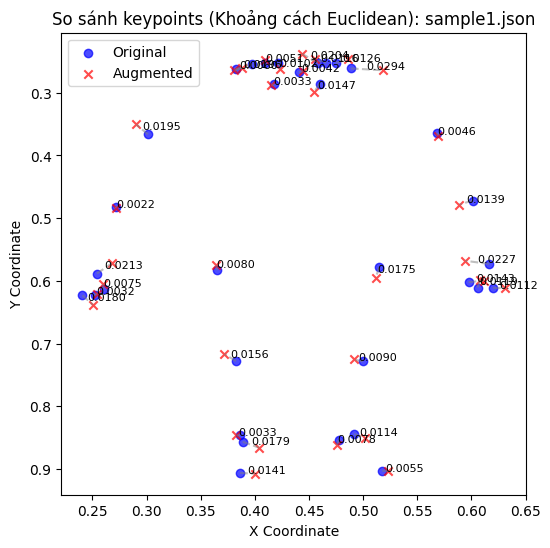


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample1.json vs data/keypoints_augmented_jittering/Garland_Pose\sample1.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00383         0.00165         0.00417
left_eye_inner       0.01463         0.01421         0.02039
left_eye             0.01021         0.00555         0.01162
left_eye_outer       0.01129         0.00568         0.01264
right_eye_inner      0.00167         0.01003         0.01017
right_eye            0.00045         0.00506         0.00508
right_eye_outer      0.01642         0.01063         0.01956
left_ear             0.02924         0.00283         0.02937
right_ear            0.00542         0.00268         0.00604
mouth_left           0.00552         0.01360         0.01468
mouth_right          0.00261         0.00202         0.00330
left_shoulder        0.00103         0.00444         0.00456
right_shoulder      

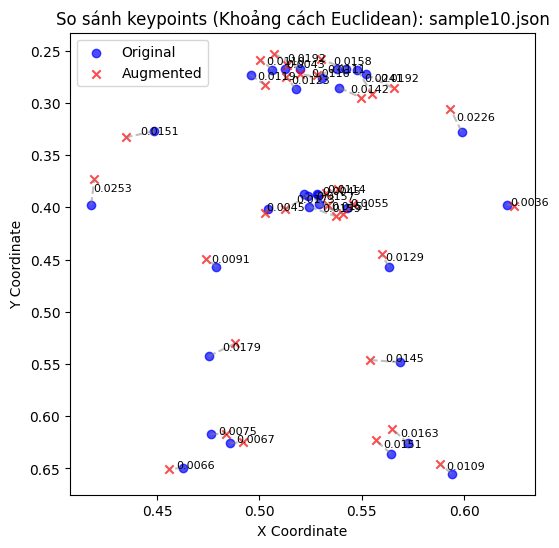


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample10.json vs data/keypoints_augmented_jittering/Garland_Pose\sample10.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01097         0.00367         0.01157
left_eye_inner       0.00938         0.00587         0.01106
left_eye             0.01239         0.00975         0.01576
left_eye_outer       0.00715         0.02305         0.02413
right_eye_inner      0.01256         0.01448         0.01917
right_eye            0.00089         0.00425         0.00434
right_eye_outer      0.00578         0.00937         0.01101
left_ear             0.01345         0.01364         0.01916
right_ear            0.00698         0.00965         0.01191
mouth_left           0.01065         0.00941         0.01421
mouth_right          0.00461         0.01145         0.01235
left_shoulder        0.00557         0.02195         0.02264
right_shoulder    

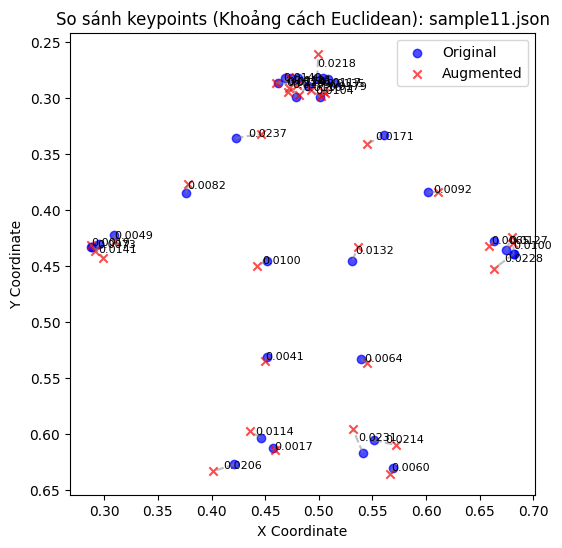


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample11.json vs data/keypoints_augmented_jittering/Garland_Pose\sample11.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00789         0.00771         0.01103
left_eye_inner       0.00104         0.02182         0.02184
left_eye             0.00029         0.01171         0.01171
left_eye_outer       0.00276         0.01324         0.01352
right_eye_inner      0.00805         0.00905         0.01212
right_eye            0.01410         0.00485         0.01491
right_eye_outer      0.00302         0.01255         0.01291
left_ear             0.01342         0.01183         0.01789
right_ear            0.01730         0.00177         0.01739
mouth_left           0.00842         0.00609         0.01039
mouth_right          0.00622         0.01783         0.01889
left_shoulder        0.01517         0.00790         0.01711
right_shoulder    

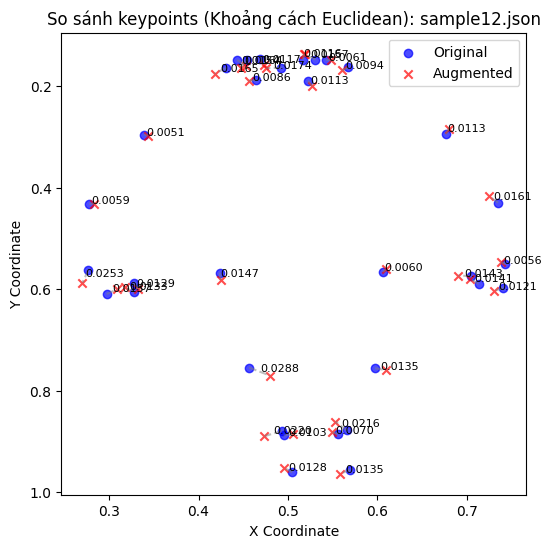


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample12.json vs data/keypoints_augmented_jittering/Garland_Pose\sample12.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01732         0.00124         0.01736
left_eye_inner       0.00095         0.01152         0.01156
left_eye             0.01149         0.01063         0.01565
left_eye_outer       0.00608         0.00079         0.00613
right_eye_inner      0.00389         0.01108         0.01175
right_eye            0.00585         0.01527         0.01636
right_eye_outer      0.00964         0.01201         0.01540
left_ear             0.00719         0.00605         0.00939
right_ear            0.01241         0.01088         0.01650
mouth_left           0.00475         0.01022         0.01127
mouth_right          0.00843         0.00141         0.00855
left_shoulder        0.00309         0.01092         0.01135
right_shoulder    

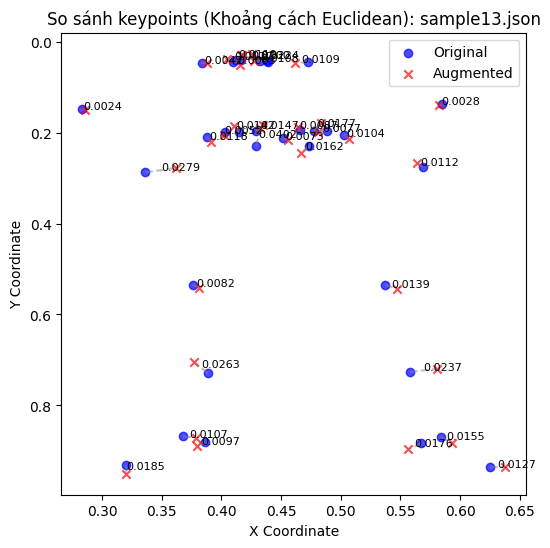


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample13.json vs data/keypoints_augmented_jittering/Garland_Pose\sample13.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00389         0.00612         0.00725
left_eye_inner       0.00198         0.00852         0.00875
left_eye             0.00581         0.01670         0.01768
left_eye_outer       0.00738         0.00236         0.00774
right_eye_inner      0.00591         0.01345         0.01469
right_eye            0.00406         0.01363         0.01422
right_eye_outer      0.00072         0.00515         0.00520
left_ear             0.00423         0.00951         0.01041
right_ear            0.00297         0.01146         0.01184
mouth_left           0.00685         0.01469         0.01621
mouth_right          0.00315         0.04007         0.04019
left_shoulder        0.00448         0.01025         0.01118
right_shoulder    

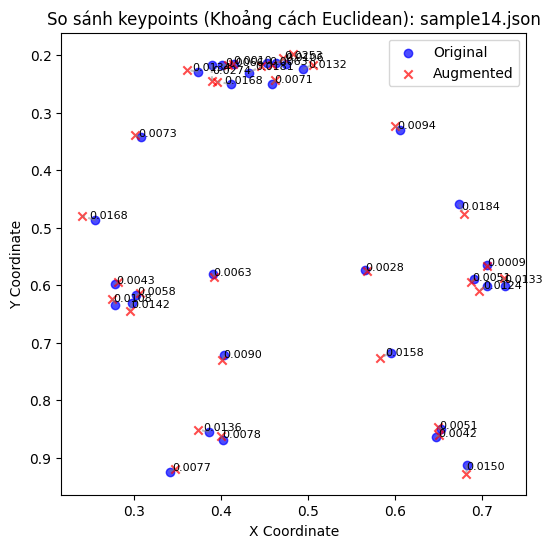


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample14.json vs data/keypoints_augmented_jittering/Garland_Pose\sample14.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01411         0.01135         0.01811
left_eye_inner       0.00553         0.00294         0.00627
left_eye             0.01917         0.01648         0.02528
left_eye_outer       0.00348         0.01001         0.01060
right_eye_inner      0.00068         0.00074         0.00101
right_eye            0.00652         0.00121         0.00664
right_eye_outer      0.00040         0.02742         0.02742
left_ear             0.01076         0.00764         0.01319
right_ear            0.01309         0.00276         0.01338
mouth_left           0.00371         0.00606         0.00711
mouth_right          0.01622         0.00438         0.01680
left_shoulder        0.00608         0.00714         0.00938
right_shoulder    

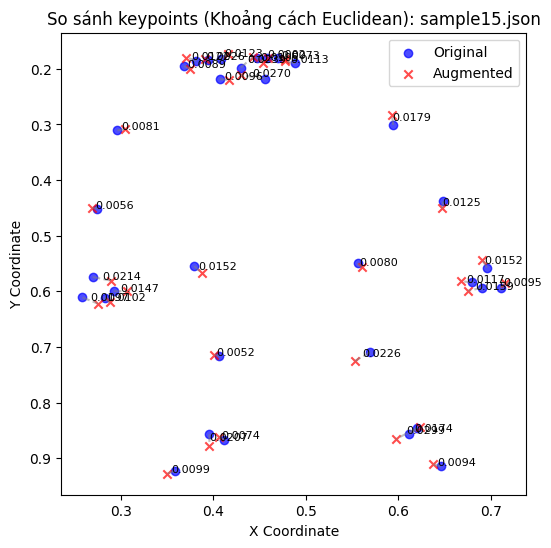


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample15.json vs data/keypoints_augmented_jittering/Garland_Pose\sample15.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01346         0.01981         0.02395
left_eye_inner       0.00605         0.00860         0.01052
left_eye             0.00017         0.00001         0.00017
left_eye_outer       0.00722         0.00118         0.00732
right_eye_inner      0.00766         0.00967         0.01233
right_eye            0.00241         0.00106         0.00263
right_eye_outer      0.01083         0.00555         0.01217
left_ear             0.01091         0.00290         0.01129
right_ear            0.00682         0.00578         0.00894
mouth_left           0.02624         0.00627         0.02698
mouth_right          0.00958         0.00088         0.00962
left_shoulder        0.00131         0.01783         0.01788
right_shoulder    

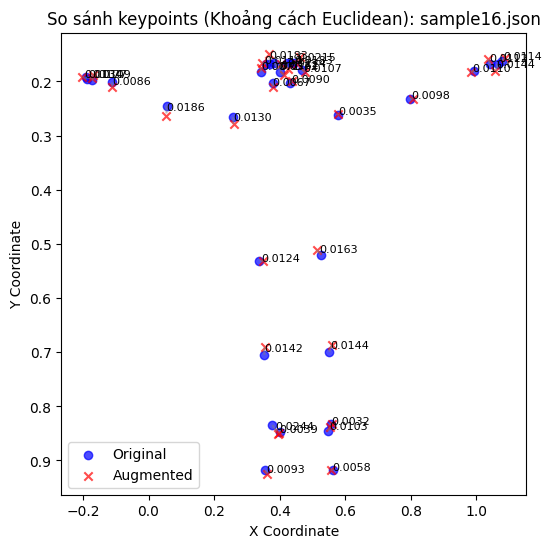


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample16.json vs data/keypoints_augmented_jittering/Garland_Pose\sample16.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00149         0.01608         0.01614
left_eye_inner       0.00216         0.01221         0.01240
left_eye             0.01813         0.00240         0.01829
left_eye_outer       0.01854         0.01082         0.02146
right_eye_inner      0.02967         0.02249         0.03723
right_eye            0.00140         0.01829         0.01834
right_eye_outer      0.01107         0.00277         0.01141
left_ear             0.00937         0.00516         0.01070
right_ear            0.00146         0.00698         0.00713
mouth_left           0.00821         0.00377         0.00903
mouth_right          0.00007         0.00673         0.00673
left_shoulder        0.00240         0.00259         0.00353
right_shoulder    

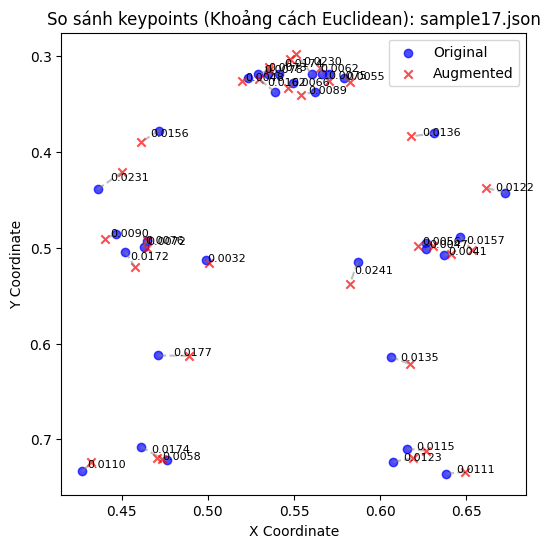


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample17.json vs data/keypoints_augmented_jittering/Garland_Pose\sample17.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00297         0.00590         0.00661
left_eye_inner       0.00923         0.02112         0.02305
left_eye             0.00100         0.00609         0.00617
left_eye_outer       0.00002         0.00751         0.00751
right_eye_inner      0.00654         0.01609         0.01737
right_eye            0.00021         0.00729         0.00729
right_eye_outer      0.00638         0.00453         0.00782
left_ear             0.00347         0.00421         0.00546
right_ear            0.00348         0.00333         0.00481
mouth_left           0.00850         0.00263         0.00890
mouth_right          0.00912         0.01339         0.01621
left_shoulder        0.01323         0.00327         0.01363
right_shoulder    

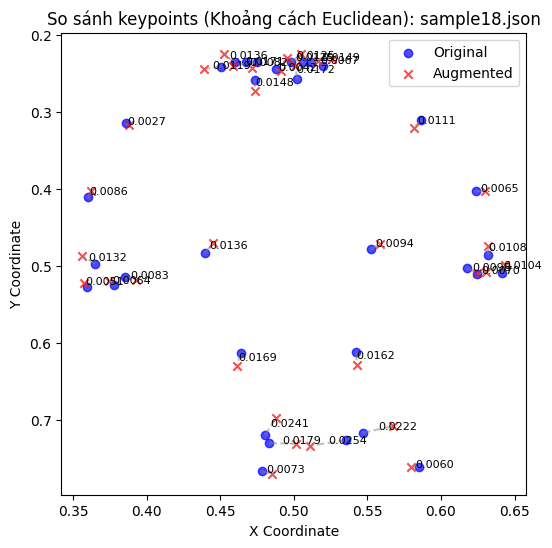


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample18.json vs data/keypoints_augmented_jittering/Garland_Pose\sample18.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00343         0.00237         0.00417
left_eye_inner       0.00679         0.01051         0.01251
left_eye             0.01120         0.00563         0.01253
left_eye_outer       0.01423         0.00456         0.01494
right_eye_inner      0.01642         0.00492         0.01714
right_eye            0.00363         0.00735         0.00819
right_eye_outer      0.00757         0.01127         0.01357
left_ear             0.00304         0.00601         0.00674
right_ear            0.01149         0.00297         0.01186
mouth_left           0.00127         0.01715         0.01720
mouth_right          0.00008         0.01485         0.01485
left_shoulder        0.00474         0.01000         0.01106
right_shoulder    

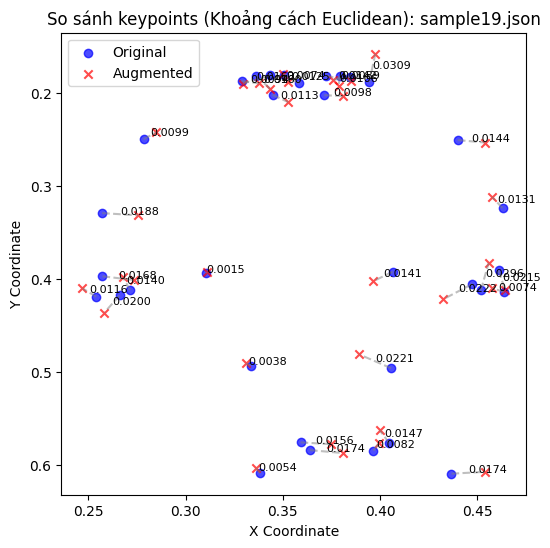


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample19.json vs data/keypoints_augmented_jittering/Garland_Pose\sample19.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00803         0.00958         0.01250
left_eye_inner       0.01309         0.00553         0.01421
left_eye             0.00054         0.01059         0.01060
left_eye_outer       0.00834         0.00311         0.00890
right_eye_inner      0.00234         0.00698         0.00736
right_eye            0.01380         0.00877         0.01635
right_eye_outer      0.00730         0.01428         0.01603
left_ear             0.00310         0.03070         0.03086
right_ear            0.00898         0.00262         0.00935
mouth_left           0.00974         0.00107         0.00979
mouth_right          0.00810         0.00789         0.01131
left_shoulder        0.01414         0.00266         0.01439
right_shoulder    

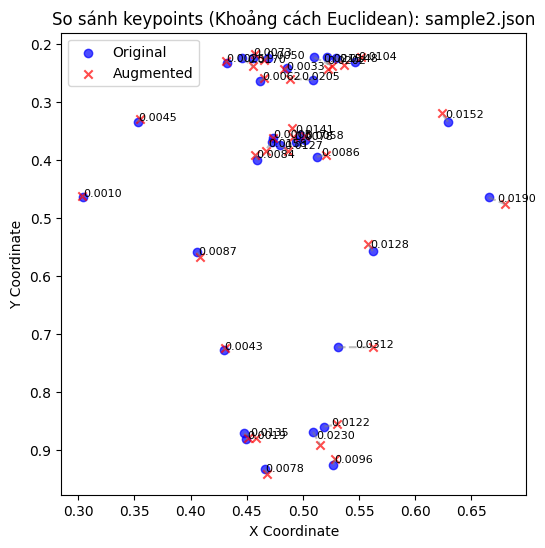


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample2.json vs data/keypoints_augmented_jittering/Garland_Pose\sample2.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00257         0.00213         0.00334
left_eye_inner       0.01613         0.01421         0.02149
left_eye             0.00091         0.02018         0.02020
left_eye_outer       0.00690         0.01313         0.01483
right_eye_inner      0.00351         0.00356         0.00500
right_eye            0.00203         0.00705         0.00733
right_eye_outer      0.00943         0.01419         0.01704
left_ear             0.00577         0.00866         0.01041
right_ear            0.00030         0.00246         0.00248
mouth_left           0.02035         0.00242         0.02049
mouth_right          0.00419         0.00454         0.00617
left_shoulder        0.00573         0.01407         0.01520
right_shoulder      

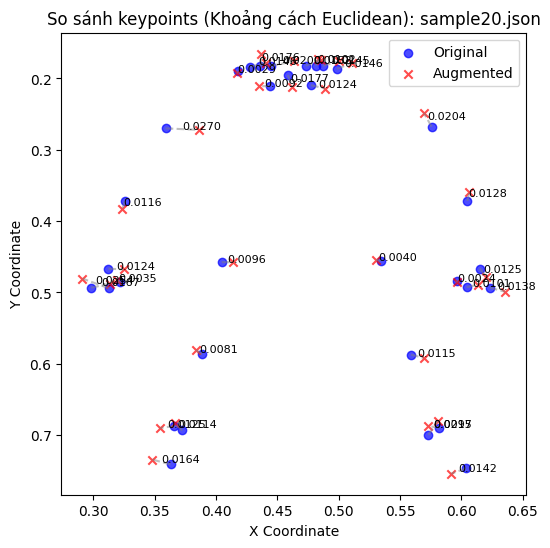


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample20.json vs data/keypoints_augmented_jittering/Garland_Pose\sample20.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00365         0.01729         0.01767
left_eye_inner       0.01278         0.00824         0.01521
left_eye             0.00226         0.00994         0.01019
left_eye_outer       0.01303         0.00632         0.01448
right_eye_inner      0.01877         0.00686         0.01999
right_eye            0.00056         0.01760         0.01761
right_eye_outer      0.01353         0.00540         0.01456
left_ear             0.01221         0.00807         0.01463
right_ear            0.00024         0.00291         0.00292
mouth_left           0.01148         0.00480         0.01244
mouth_right          0.00916         0.00082         0.00920
left_shoulder        0.00641         0.01939         0.02042
right_shoulder    

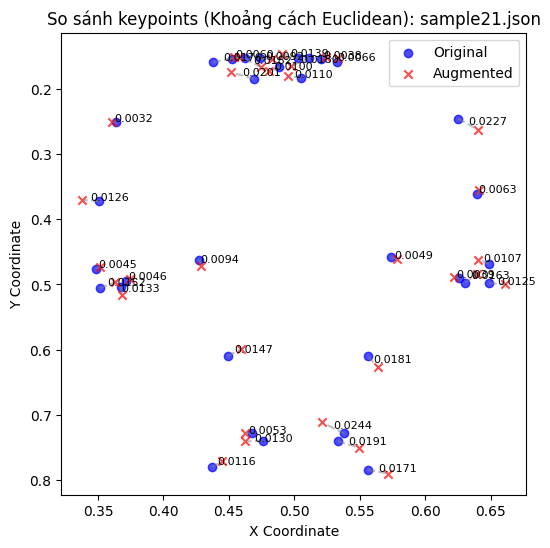


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample21.json vs data/keypoints_augmented_jittering/Garland_Pose\sample21.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00807         0.00590         0.01000
left_eye_inner       0.01195         0.00707         0.01389
left_eye             0.01358         0.01181         0.01800
left_eye_outer       0.00334         0.00182         0.00380
right_eye_inner      0.00902         0.00166         0.00917
right_eye            0.01237         0.01341         0.01824
right_eye_outer      0.00516         0.00298         0.00596
left_ear             0.00086         0.00659         0.00665
right_ear            0.01585         0.00756         0.01756
mouth_left           0.01059         0.00284         0.01096
mouth_right          0.01749         0.00997         0.02013
left_shoulder        0.01528         0.01680         0.02271
right_shoulder    

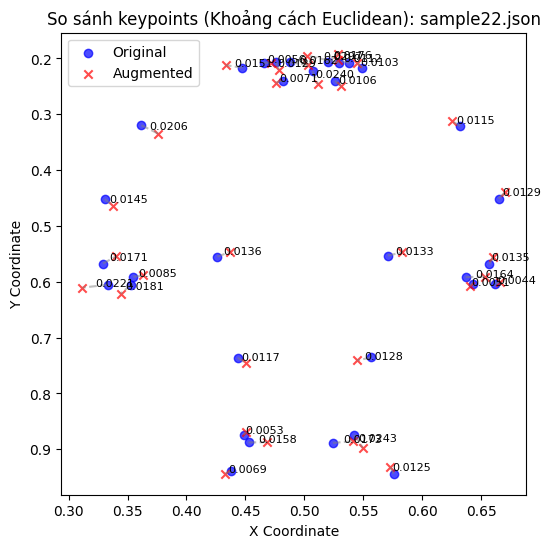


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample22.json vs data/keypoints_augmented_jittering/Garland_Pose\sample22.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00457         0.02361         0.02405
left_eye_inner       0.00810         0.01566         0.01764
left_eye             0.02684         0.01263         0.02966
left_eye_outer       0.00988         0.00521         0.01117
right_eye_inner      0.01545         0.00494         0.01622
right_eye            0.00226         0.01269         0.01289
right_eye_outer      0.00563         0.00030         0.00564
left_ear             0.00422         0.00943         0.01033
right_ear            0.01427         0.00491         0.01509
mouth_left           0.00536         0.00917         0.01062
mouth_right          0.00593         0.00386         0.00708
left_shoulder        0.00702         0.00909         0.01149
right_shoulder    

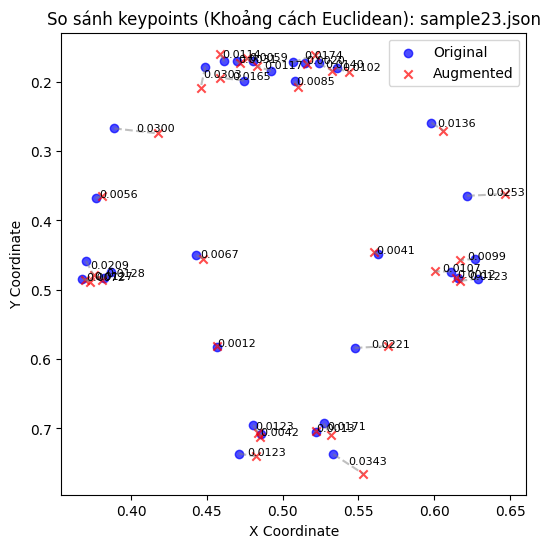


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample23.json vs data/keypoints_augmented_jittering/Garland_Pose\sample23.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00928         0.00713         0.01171
left_eye_inner       0.01431         0.00989         0.01740
left_eye             0.00133         0.00152         0.00202
left_eye_outer       0.00895         0.01072         0.01397
right_eye_inner      0.00374         0.00454         0.00589
right_eye            0.00181         0.00252         0.00311
right_eye_outer      0.00270         0.01110         0.01142
left_ear             0.00787         0.00641         0.01015
right_ear            0.00295         0.03018         0.03032
mouth_left           0.00236         0.00815         0.00848
mouth_right          0.01602         0.00410         0.01653
left_shoulder        0.00783         0.01117         0.01364
right_shoulder    

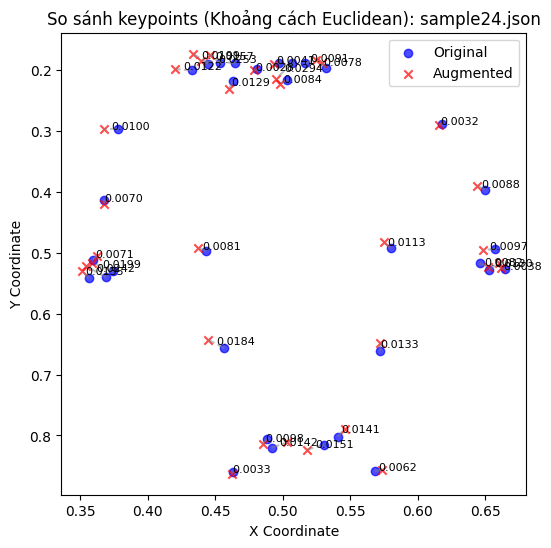


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample24.json vs data/keypoints_augmented_jittering/Garland_Pose\sample24.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00235         0.00147         0.00277
left_eye_inner       0.00381         0.00152         0.00410
left_eye             0.01156         0.02707         0.02943
left_eye_outer       0.00808         0.00418         0.00910
right_eye_inner      0.02517         0.00275         0.02532
right_eye            0.00740         0.01384         0.01569
right_eye_outer      0.01096         0.01658         0.01988
left_ear             0.00273         0.00726         0.00775
right_ear            0.01205         0.00180         0.01219
mouth_left           0.00565         0.00626         0.00843
mouth_right          0.00258         0.01260         0.01287
left_shoulder        0.00201         0.00248         0.00319
right_shoulder    

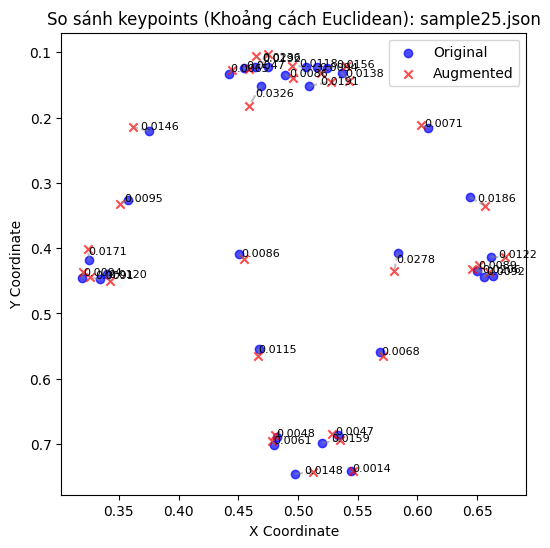


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample25.json vs data/keypoints_augmented_jittering/Garland_Pose\sample25.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00697         0.00508         0.00863
left_eye_inner       0.01170         0.00164         0.01181
left_eye             0.00342         0.00880         0.00945
left_eye_outer       0.01543         0.00224         0.01559
right_eye_inner      0.01002         0.01635         0.01918
right_eye            0.01082         0.02092         0.02355
right_eye_outer      0.00447         0.00152         0.00472
left_ear             0.00597         0.01244         0.01380
right_ear            0.00246         0.00603         0.00651
mouth_left           0.01793         0.00646         0.01905
mouth_right          0.00978         0.03111         0.03261
left_shoulder        0.00634         0.00318         0.00709
right_shoulder    

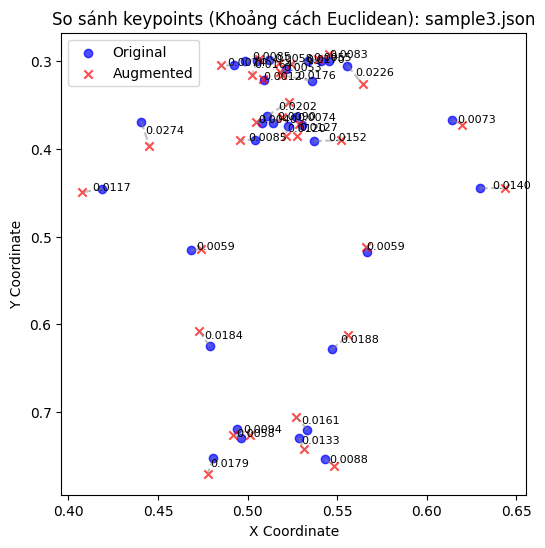


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample3.json vs data/keypoints_augmented_jittering/Garland_Pose\sample3.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00374         0.00375         0.00530
left_eye_inner       0.00527         0.00145         0.00547
left_eye             0.01661         0.00362         0.01700
left_eye_outer       0.00008         0.00833         0.00833
right_eye_inner      0.00525         0.00244         0.00579
right_eye            0.00301         0.01613         0.01641
right_eye_outer      0.00813         0.00240         0.00848
left_ear             0.00866         0.02091         0.02263
right_ear            0.00738         0.00006         0.00738
mouth_left           0.01659         0.00596         0.01763
mouth_right          0.00060         0.00109         0.00124
left_shoulder        0.00530         0.00508         0.00734
right_shoulder      

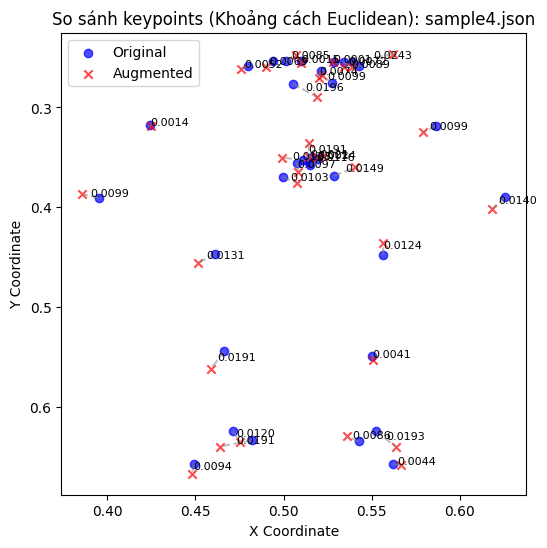


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample4.json vs data/keypoints_augmented_jittering/Garland_Pose\sample4.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00119         0.00727         0.00737
left_eye_inner       0.00010         0.00001         0.00010
left_eye             0.00471         0.00550         0.00725
left_eye_outer       0.02273         0.00847         0.02426
right_eye_inner      0.00044         0.00148         0.00155
right_eye            0.00550         0.00653         0.00854
right_eye_outer      0.00407         0.00555         0.00688
left_ear             0.00879         0.00111         0.00886
right_ear            0.00375         0.00355         0.00517
mouth_left           0.00561         0.00820         0.00993
mouth_right          0.01399         0.01372         0.01960
left_shoulder        0.00719         0.00678         0.00988
right_shoulder      

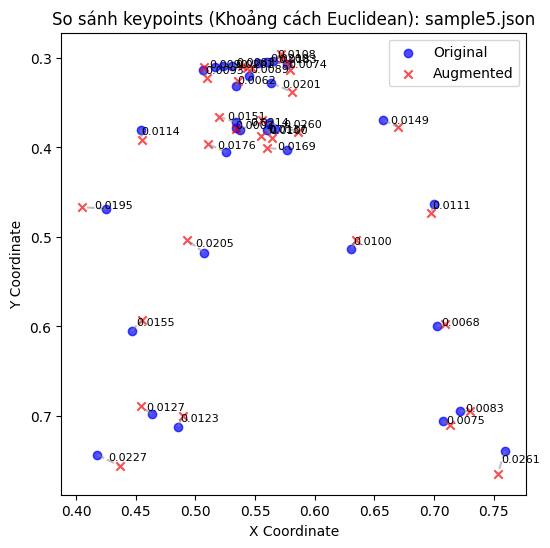


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample5.json vs data/keypoints_augmented_jittering/Garland_Pose\sample5.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00273         0.00842         0.00885
left_eye_inner       0.01947         0.00473         0.02003
left_eye             0.01830         0.00047         0.01830
left_eye_outer       0.00662         0.00852         0.01079
right_eye_inner      0.00832         0.00023         0.00833
right_eye            0.02000         0.00178         0.02008
right_eye_outer      0.00902         0.00014         0.00902
left_ear             0.00272         0.00693         0.00745
right_ear            0.00287         0.00884         0.00930
mouth_left           0.01737         0.01008         0.02008
mouth_right          0.00197         0.00591         0.00623
left_shoulder        0.01252         0.00816         0.01494
right_shoulder      

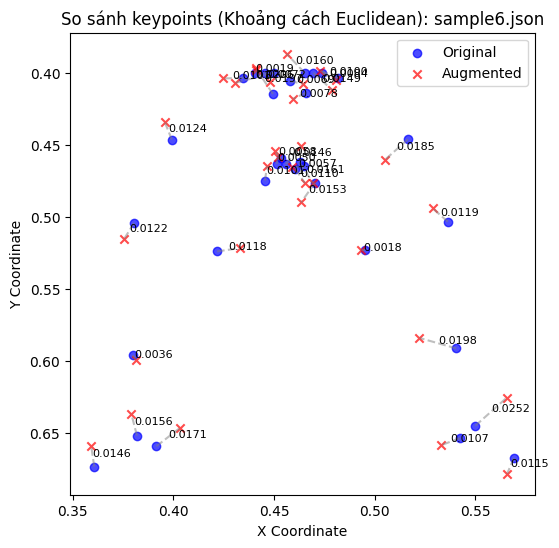


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample6.json vs data/keypoints_augmented_jittering/Garland_Pose\sample6.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00668         0.00183         0.00693
left_eye_inner       0.00896         0.01321         0.01596
left_eye             0.00917         0.01179         0.01494
left_eye_outer       0.00681         0.00489         0.00838
right_eye_inner      0.01934         0.00710         0.02060
right_eye            0.00272         0.00670         0.00723
right_eye_outer      0.00035         0.00186         0.00189
left_ear             0.00886         0.00471         0.01003
right_ear            0.01014         0.00039         0.01015
mouth_left           0.00651         0.00424         0.00777
mouth_right          0.00846         0.01773         0.01965
left_shoulder        0.01153         0.01443         0.01847
right_shoulder      

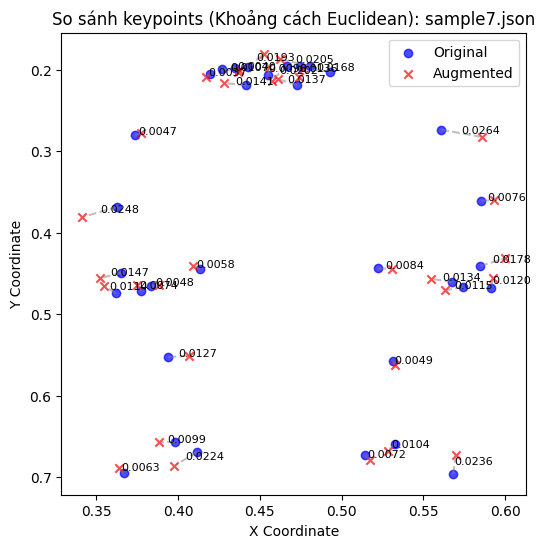


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample7.json vs data/keypoints_augmented_jittering/Garland_Pose\sample7.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00028         0.00961         0.00962
left_eye_inner       0.00941         0.01792         0.02024
left_eye             0.00100         0.01353         0.01357
left_eye_outer       0.01871         0.00841         0.02051
right_eye_inner      0.01006         0.01645         0.01928
right_eye            0.00241         0.00317         0.00398
right_eye_outer      0.00988         0.00415         0.01072
left_ear             0.01652         0.00299         0.01679
right_ear            0.00245         0.00282         0.00374
mouth_left           0.01154         0.00735         0.01368
mouth_right          0.01378         0.00307         0.01412
left_shoulder        0.02484         0.00882         0.02636
right_shoulder      

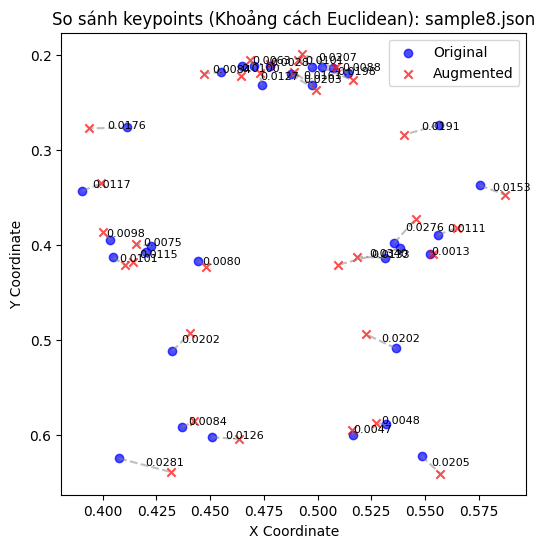


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample8.json vs data/keypoints_augmented_jittering/Garland_Pose\sample8.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01193         0.01641         0.02029
left_eye_inner       0.00637         0.00783         0.01010
left_eye             0.01443         0.01350         0.01976
left_eye_outer       0.01442         0.01491         0.02074
right_eye_inner      0.00031         0.00280         0.00282
right_eye            0.00196         0.00603         0.00634
right_eye_outer      0.00047         0.01000         0.01001
left_ear             0.00569         0.00669         0.00878
right_ear            0.00819         0.00184         0.00839
mouth_left           0.00867         0.01358         0.01611
mouth_right          0.00098         0.01261         0.01265
left_shoulder        0.01599         0.01040         0.01907
right_shoulder      

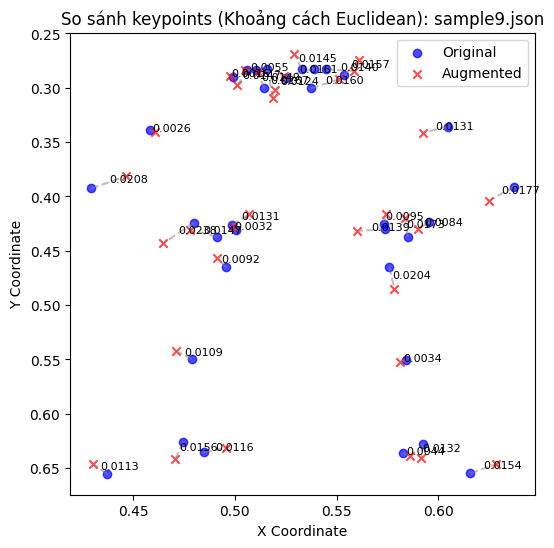


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample9.json vs data/keypoints_augmented_jittering/Garland_Pose\sample9.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00554         0.01115         0.01245
left_eye_inner       0.00390         0.01398         0.01451
left_eye             0.01470         0.00654         0.01609
left_eye_outer       0.01390         0.00157         0.01399
right_eye_inner      0.00295         0.02650         0.02666
right_eye            0.00542         0.00056         0.00545
right_eye_outer      0.00500         0.01385         0.01473
left_ear             0.00704         0.01405         0.01572
right_ear            0.00153         0.00048         0.00161
mouth_left           0.01381         0.00815         0.01603
mouth_right          0.00308         0.01453         0.01485
left_shoulder        0.01199         0.00540         0.01315
right_shoulder      

In [32]:
original_folder = "data/keypoints/Garland_Pose"
augmented_folder = "data/keypoints_augmented_jittering/Garland_Pose"

visualize_folder(original_folder, augmented_folder)


🚀 Visualizing sample1.json ...


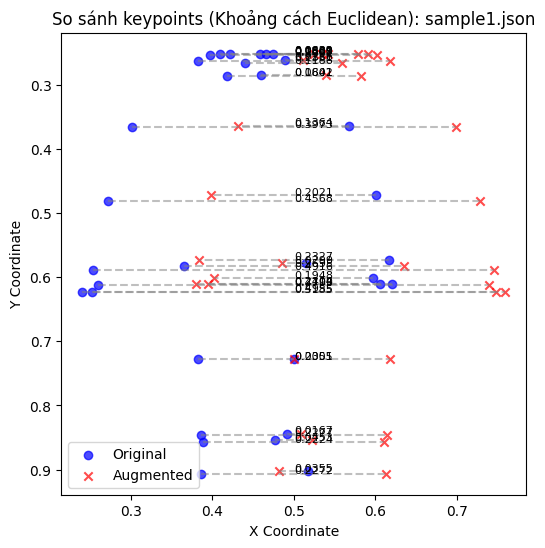


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample1.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample1.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.11859         0.00000         0.11859
left_eye_inner       0.08389         0.00000         0.08389
left_eye             0.06816         0.00000         0.06816
left_eye_outer       0.05002         0.00000         0.05002
right_eye_inner      0.15652         0.00000         0.15652
right_eye            0.18085         0.00000         0.18085
right_eye_outer      0.20506         0.00000         0.20506
left_ear             0.02261         0.00000         0.02261
right_ear            0.23509         0.00000         0.23509
mouth_left           0.08012         0.00000         0.08012
mouth_right          0.16421         0.00000         0.16421
left_shoulder        0.13639         0.00000         0.13639
right_shoulder

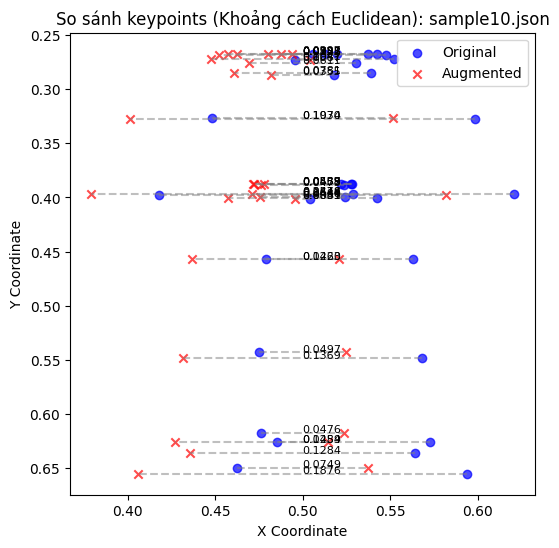


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample10.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample10.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.06113         0.00000         0.06113
left_eye_inner       0.07529         0.00000         0.07529
left_eye             0.08478         0.00000         0.08478
left_eye_outer       0.09554         0.00000         0.09554
right_eye_inner      0.03968         0.00000         0.03968
right_eye            0.02513         0.00000         0.02513
right_eye_outer      0.01251         0.00000         0.01251
left_ear             0.10407         0.00000         0.10407
right_ear            0.00875         0.00000         0.00875
mouth_left           0.07806         0.00000         0.07806
mouth_right          0.03547         0.00000         0.03547
left_shoulder        0.19743         0.00000         0.19743
right_should

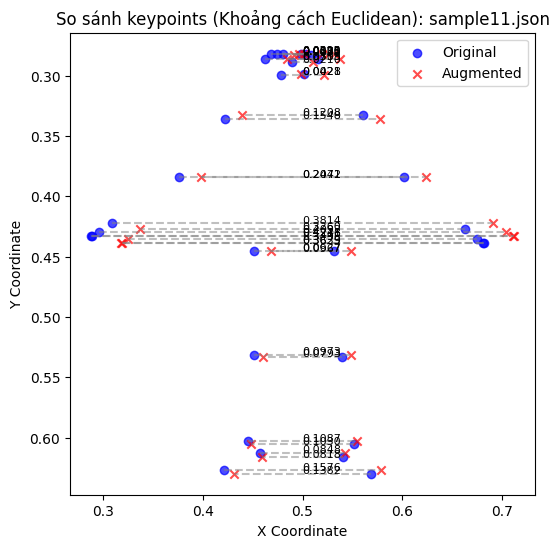


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample11.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample11.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.02101         0.00000         0.02101
left_eye_inner       0.00310         0.00000         0.00310
left_eye             0.00699         0.00000         0.00699
left_eye_outer       0.01654         0.00000         0.01654
right_eye_inner      0.03927         0.00000         0.03927
right_eye            0.05152         0.00000         0.05152
right_eye_outer      0.06295         0.00000         0.06295
left_ear             0.03088         0.00000         0.03088
right_ear            0.07528         0.00000         0.07528
mouth_left           0.00210         0.00000         0.00210
mouth_right          0.04275         0.00000         0.04275
left_shoulder        0.12077         0.00000         0.12077
right_should

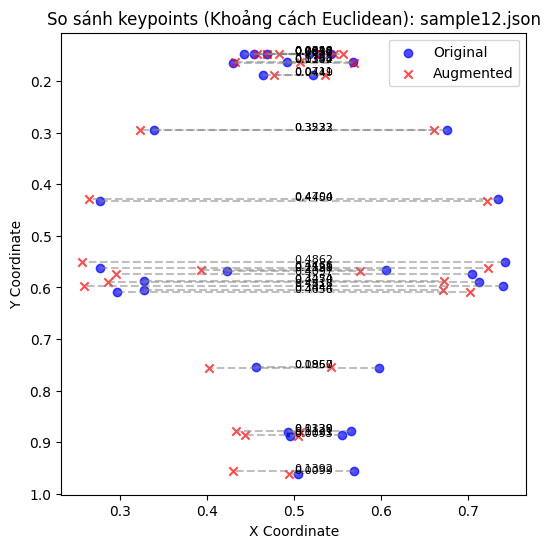


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample12.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample12.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01444         0.00000         0.01444
left_eye_inner       0.03401         0.00000         0.03401
left_eye             0.06145         0.00000         0.06145
left_eye_outer       0.08501         0.00000         0.08501
right_eye_inner      0.06181         0.00000         0.06181
right_eye            0.09224         0.00000         0.09224
right_eye_outer      0.11343         0.00000         0.11343
left_ear             0.13555         0.00000         0.13555
right_ear            0.13921         0.00000         0.13921
mouth_left           0.04491         0.00000         0.04491
mouth_right          0.07106         0.00000         0.07106
left_shoulder        0.35334         0.00000         0.35334
right_should

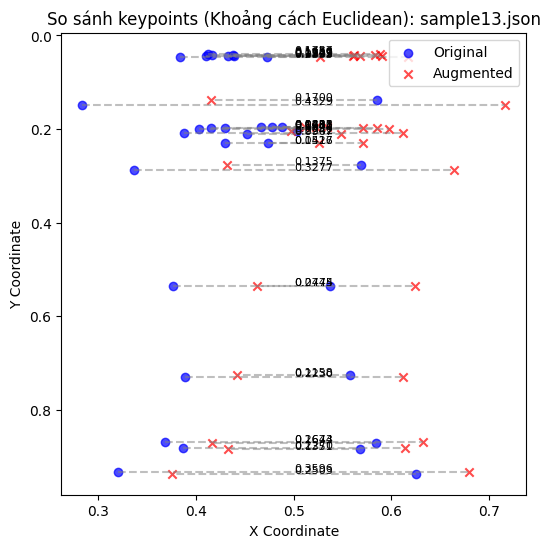


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample13.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample13.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.09668         0.00000         0.09668
left_eye_inner       0.06806         0.00000         0.06806
left_eye             0.04528         0.00000         0.04528
left_eye_outer       0.02363         0.00000         0.02363
right_eye_inner      0.14129         0.00000         0.14129
right_eye            0.17024         0.00000         0.17024
right_eye_outer      0.19408         0.00000         0.19408
left_ear             0.00563         0.00000         0.00563
right_ear            0.22417         0.00000         0.22417
mouth_left           0.05268         0.00000         0.05268
mouth_right          0.14157         0.00000         0.14157
left_shoulder        0.13753         0.00000         0.13753
right_should

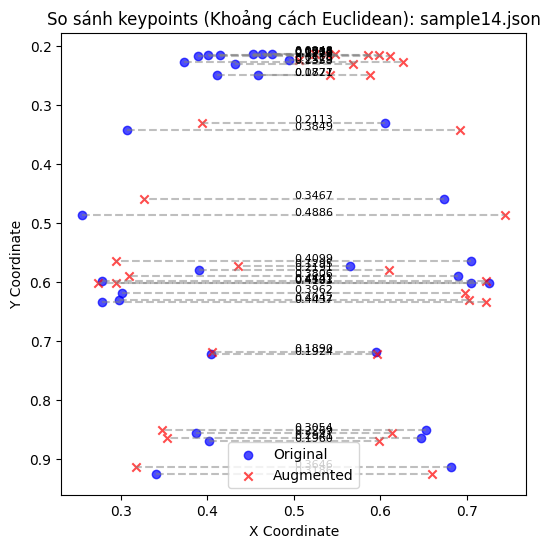


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample14.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample14.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.13583         0.00000         0.13583
left_eye_inner       0.09484         0.00000         0.09484
left_eye             0.07379         0.00000         0.07379
left_eye_outer       0.05012         0.00000         0.05012
right_eye_inner      0.17141         0.00000         0.17141
right_eye            0.19789         0.00000         0.19789
right_eye_outer      0.22188         0.00000         0.22188
left_ear             0.01178         0.00000         0.01178
right_ear            0.25292         0.00000         0.25292
mouth_left           0.08268         0.00000         0.08268
mouth_right          0.17706         0.00000         0.17706
left_shoulder        0.21127         0.00000         0.21127
right_should

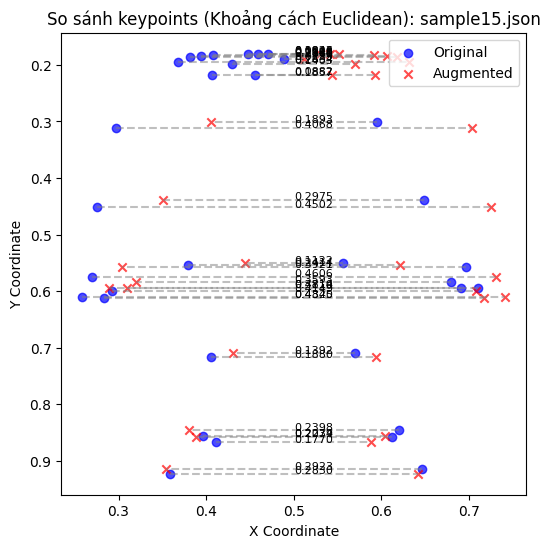


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample15.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample15.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.14026         0.00000         0.14026
left_eye_inner       0.10429         0.00000         0.10429
left_eye             0.08257         0.00000         0.08257
left_eye_outer       0.05982         0.00000         0.05982
right_eye_inner      0.18398         0.00000         0.18398
right_eye            0.21179         0.00000         0.21179
right_eye_outer      0.23611         0.00000         0.23611
left_ear             0.02289         0.00000         0.02289
right_ear            0.26338         0.00000         0.26338
mouth_left           0.08817         0.00000         0.08817
mouth_right          0.18574         0.00000         0.18574
left_shoulder        0.18925         0.00000         0.18925
right_should

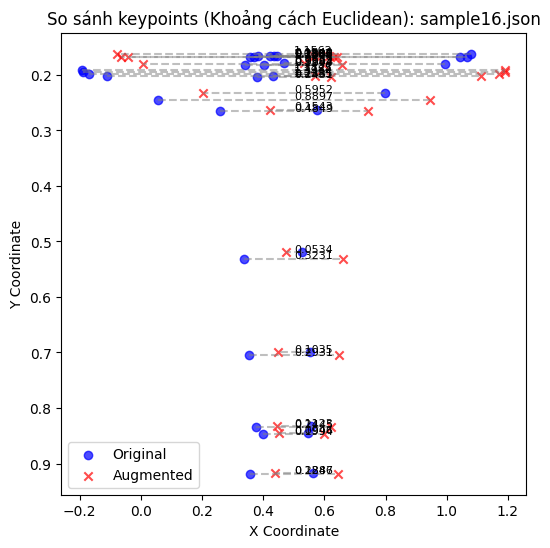


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample16.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample16.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.19442         0.00000         0.19442
left_eye_inner       0.15401         0.00000         0.15401
left_eye             0.13051         0.00000         0.13051
left_eye_outer       0.11159         0.00000         0.11159
right_eye_inner      0.23347         0.00000         0.23347
right_eye            0.26023         0.00000         0.26023
right_eye_outer      0.28470         0.00000         0.28470
left_ear             0.06392         0.00000         0.06392
right_ear            0.31605         0.00000         0.31605
mouth_left           0.13854         0.00000         0.13854
mouth_right          0.24314         0.00000         0.24314
left_shoulder        0.15432         0.00000         0.15432
right_should

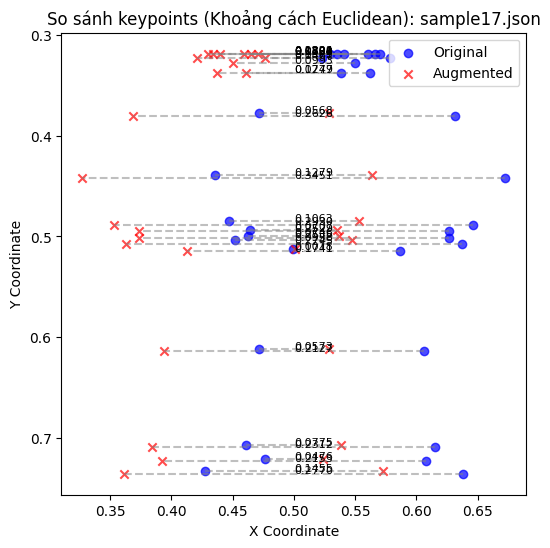


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample17.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample17.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.09934         0.00000         0.09934
left_eye_inner       0.12045         0.00000         0.12045
left_eye             0.13201         0.00000         0.13201
left_eye_outer       0.14016         0.00000         0.14016
right_eye_inner      0.08207         0.00000         0.08207
right_eye            0.07040         0.00000         0.07040
right_eye_outer      0.05879         0.00000         0.05879
left_ear             0.15752         0.00000         0.15752
right_ear            0.04666         0.00000         0.04666
mouth_left           0.12465         0.00000         0.12465
mouth_right          0.07787         0.00000         0.07787
left_shoulder        0.26263         0.00000         0.26263
right_should

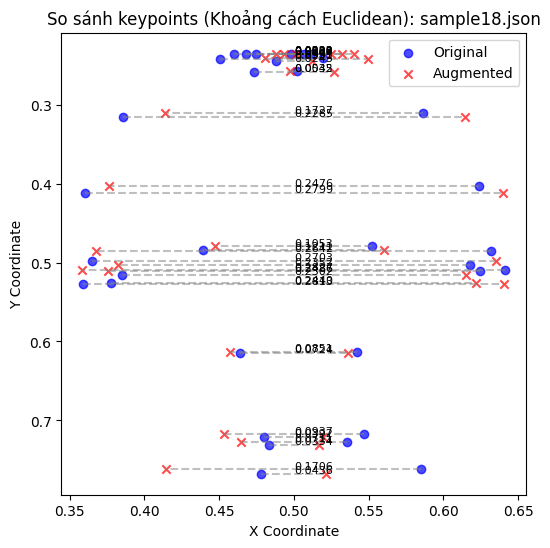


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample18.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample18.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.02432         0.00000         0.02432
left_eye_inner       0.00329         0.00000         0.00329
left_eye             0.01304         0.00000         0.01304
left_eye_outer       0.02349         0.00000         0.02349
right_eye_inner      0.05003         0.00000         0.05003
right_eye            0.06442         0.00000         0.06442
right_eye_outer      0.08024         0.00000         0.08024
left_ear             0.03910         0.00000         0.03910
right_ear            0.09911         0.00000         0.09911
mouth_left           0.00451         0.00000         0.00451
mouth_right          0.05323         0.00000         0.05323
left_shoulder        0.17271         0.00000         0.17271
right_should

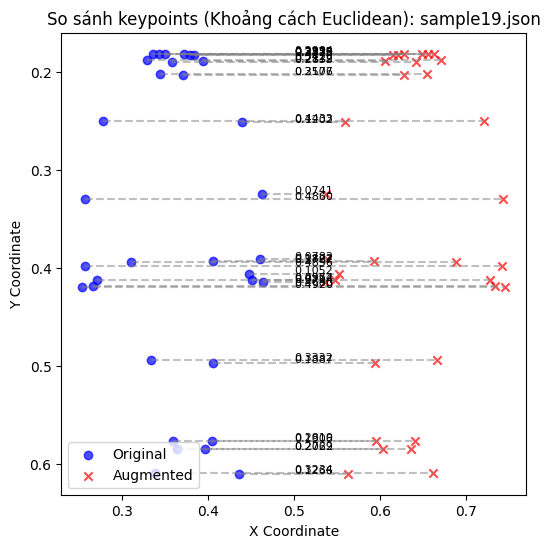


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample19.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample19.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.28354         0.00000         0.28354
left_eye_inner       0.25593         0.00000         0.25593
left_eye             0.24160         0.00000         0.24160
left_eye_outer       0.23134         0.00000         0.23134
right_eye_inner      0.29941         0.00000         0.29941
right_eye            0.31352         0.00000         0.31352
right_eye_outer      0.32753         0.00000         0.32753
left_ear             0.21119         0.00000         0.21119
right_ear            0.34258         0.00000         0.34258
mouth_left           0.25760         0.00000         0.25760
mouth_right          0.31072         0.00000         0.31072
left_shoulder        0.12015         0.00000         0.12015
right_should

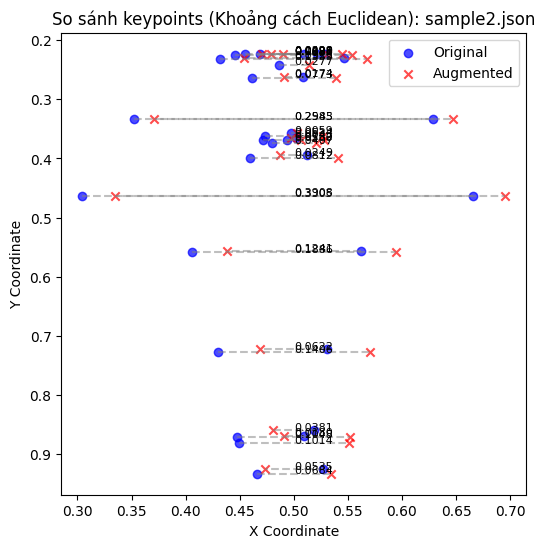


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample2.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample2.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.02774         0.00000         0.02774
left_eye_inner       0.01979         0.00000         0.01979
left_eye             0.04290         0.00000         0.04290
left_eye_outer       0.05853         0.00000         0.05853
right_eye_inner      0.06206         0.00000         0.06206
right_eye            0.08977         0.00000         0.08977
right_eye_outer      0.10804         0.00000         0.10804
left_ear             0.09227         0.00000         0.09227
right_ear            0.13588         0.00000         0.13588
mouth_left           0.01742         0.00000         0.01742
mouth_right          0.07726         0.00000         0.07726
left_shoulder        0.25830         0.00000         0.25830
right_shoulder

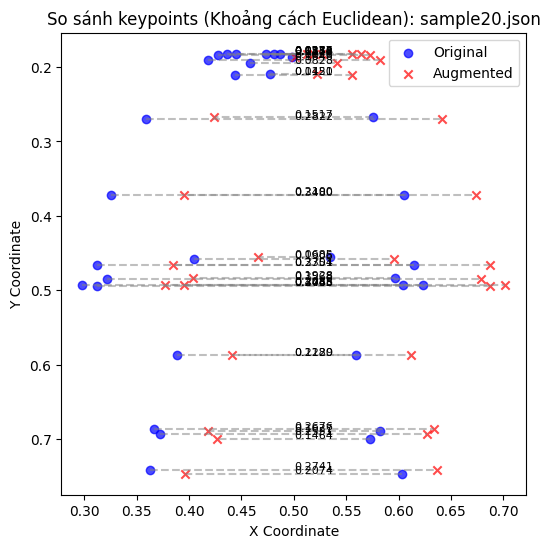


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample20.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample20.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.08282         0.00000         0.08282
left_eye_inner       0.05373         0.00000         0.05373
left_eye             0.03744         0.00000         0.03744
left_eye_outer       0.02546         0.00000         0.02546
right_eye_inner      0.11102         0.00000         0.11102
right_eye            0.12739         0.00000         0.12739
right_eye_outer      0.14480         0.00000         0.14480
left_ear             0.00263         0.00000         0.00263
right_ear            0.16460         0.00000         0.16460
mouth_left           0.04504         0.00000         0.04504
mouth_right          0.11206         0.00000         0.11206
left_shoulder        0.15165         0.00000         0.15165
right_should

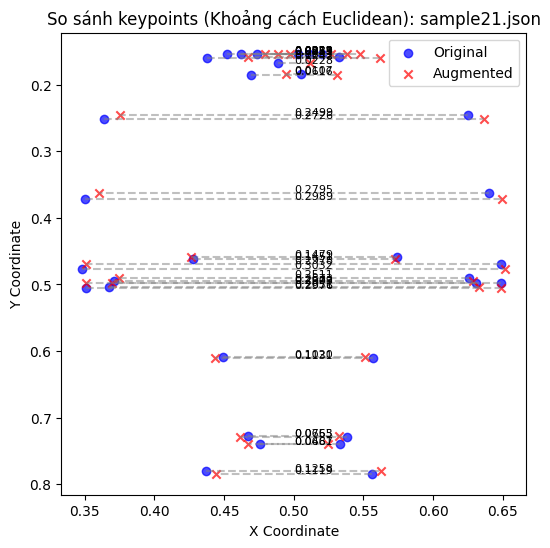


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample21.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample21.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.02282         0.00000         0.02282
left_eye_inner       0.00552         0.00000         0.00552
left_eye             0.02243         0.00000         0.02243
left_eye_outer       0.04108         0.00000         0.04108
right_eye_inner      0.05286         0.00000         0.05286
right_eye            0.07573         0.00000         0.07573
right_eye_outer      0.09568         0.00000         0.09568
left_ear             0.06526         0.00000         0.06526
right_ear            0.12417         0.00000         0.12417
mouth_left           0.01074         0.00000         0.01074
mouth_right          0.06165         0.00000         0.06165
left_shoulder        0.24994         0.00000         0.24994
right_should

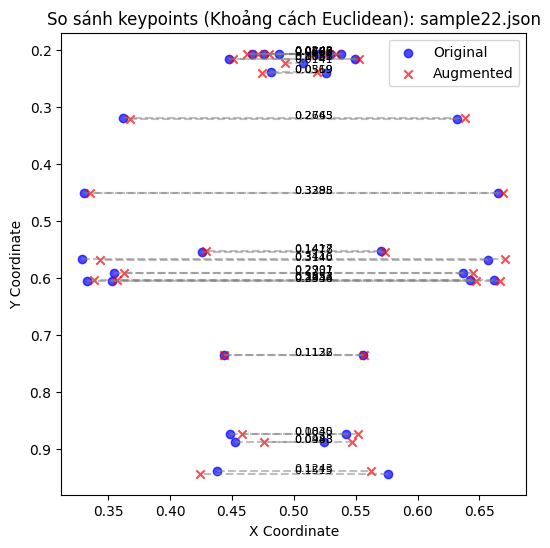


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample22.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample22.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01412         0.00000         0.01412
left_eye_inner       0.04057         0.00000         0.04057
left_eye             0.05821         0.00000         0.05821
left_eye_outer       0.07631         0.00000         0.07631
right_eye_inner      0.02433         0.00000         0.02433
right_eye            0.04793         0.00000         0.04793
right_eye_outer      0.06826         0.00000         0.06826
left_ear             0.09847         0.00000         0.09847
right_ear            0.10520         0.00000         0.10520
mouth_left           0.05192         0.00000         0.05192
mouth_right          0.03690         0.00000         0.03690
left_shoulder        0.26435         0.00000         0.26435
right_should

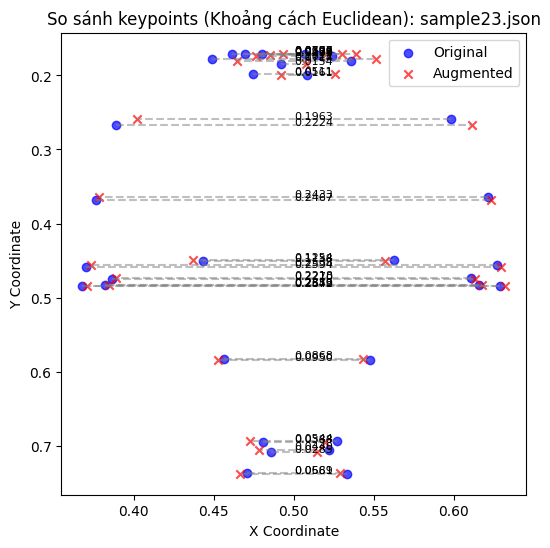


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample23.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample23.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01540         0.00000         0.01540
left_eye_inner       0.01382         0.00000         0.01382
left_eye             0.02991         0.00000         0.02991
left_eye_outer       0.04731         0.00000         0.04731
right_eye_inner      0.03971         0.00000         0.03971
right_eye            0.06056         0.00000         0.06056
right_eye_outer      0.07722         0.00000         0.07722
left_ear             0.07140         0.00000         0.07140
right_ear            0.10216         0.00000         0.10216
mouth_left           0.01613         0.00000         0.01613
mouth_right          0.05107         0.00000         0.05107
left_shoulder        0.19634         0.00000         0.19634
right_should

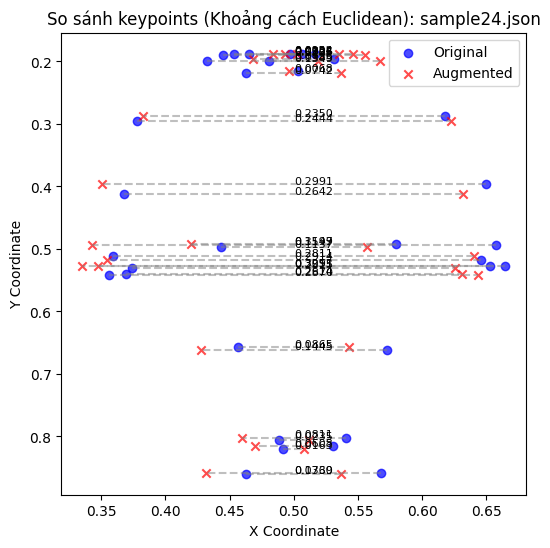


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample24.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample24.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.03845         0.00000         0.03845
left_eye_inner       0.00541         0.00000         0.00541
left_eye             0.01323         0.00000         0.01323
left_eye_outer       0.03251         0.00000         0.03251
right_eye_inner      0.07047         0.00000         0.07047
right_eye            0.09241         0.00000         0.09241
right_eye_outer      0.11051         0.00000         0.11051
left_ear             0.06326         0.00000         0.06326
right_ear            0.13485         0.00000         0.13485
mouth_left           0.00677         0.00000         0.00677
mouth_right          0.07417         0.00000         0.07417
left_shoulder        0.23498         0.00000         0.23498
right_should

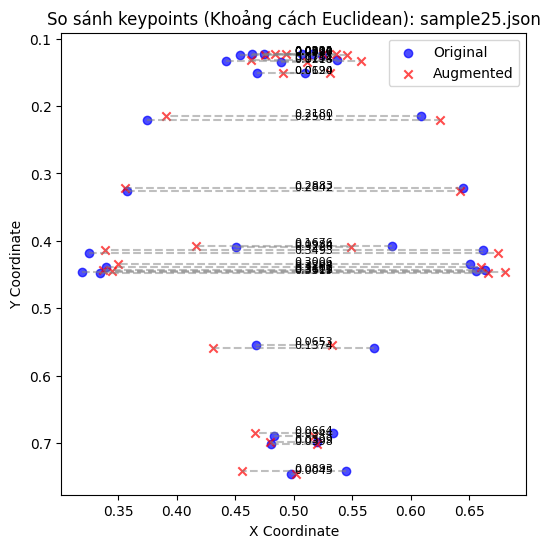


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample25.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample25.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.02180         0.00000         0.02180
left_eye_inner       0.01337         0.00000         0.01337
left_eye             0.03198         0.00000         0.03198
left_eye_outer       0.04901         0.00000         0.04901
right_eye_inner      0.05010         0.00000         0.05010
right_eye            0.07153         0.00000         0.07153
right_eye_outer      0.09102         0.00000         0.09102
left_ear             0.07309         0.00000         0.07309
right_ear            0.11540         0.00000         0.11540
mouth_left           0.01896         0.00000         0.01896
mouth_right          0.06237         0.00000         0.06237
left_shoulder        0.21802         0.00000         0.21802
right_should

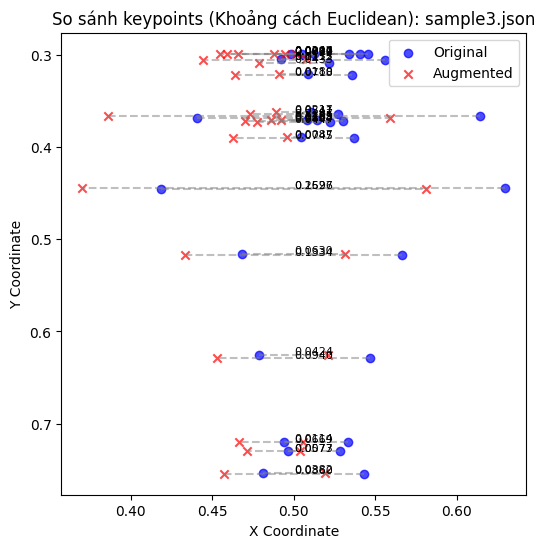


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample3.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample3.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.04329         0.00000         0.04329
left_eye_inner       0.06796         0.00000         0.06796
left_eye             0.08169         0.00000         0.08169
left_eye_outer       0.09108         0.00000         0.09108
right_eye_inner      0.02436         0.00000         0.02436
right_eye            0.01069         0.00000         0.01069
right_eye_outer      0.00295         0.00000         0.00295
left_ear             0.11154         0.00000         0.11154
right_ear            0.01522         0.00000         0.01522
mouth_left           0.07181         0.00000         0.07181
mouth_right          0.01797         0.00000         0.01797
left_shoulder        0.22870         0.00000         0.22870
right_shoulder

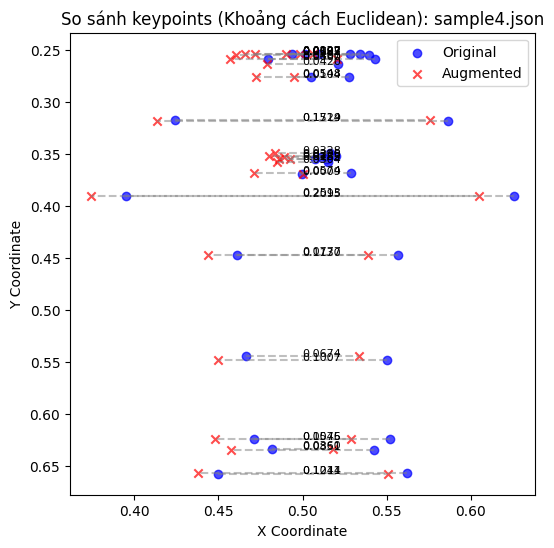


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample4.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample4.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.04204         0.00000         0.04204
left_eye_inner       0.05672         0.00000         0.05672
left_eye             0.06823         0.00000         0.06823
left_eye_outer       0.07920         0.00000         0.07920
right_eye_inner      0.01947         0.00000         0.01947
right_eye            0.00270         0.00000         0.00270
right_eye_outer      0.01222         0.00000         0.01222
left_ear             0.08600         0.00000         0.08600
right_ear            0.04068         0.00000         0.04068
mouth_left           0.05480         0.00000         0.05480
mouth_right          0.01040         0.00000         0.01040
left_shoulder        0.17290         0.00000         0.17290
right_shoulder

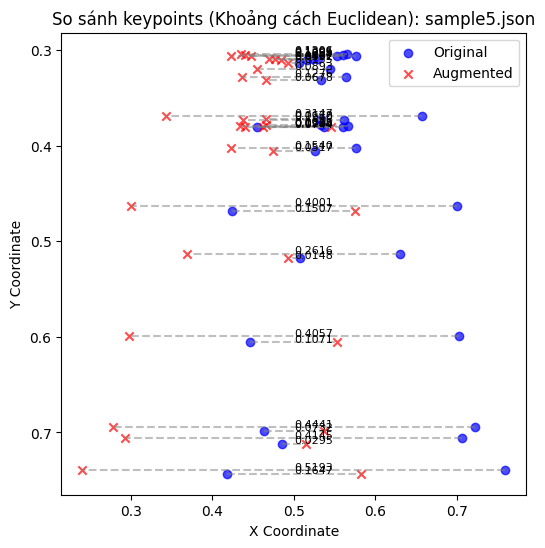


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample5.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample5.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.08925         0.00000         0.08925
left_eye_inner       0.10554         0.00000         0.10554
left_eye             0.12051         0.00000         0.12051
left_eye_outer       0.13058         0.00000         0.13058
right_eye_inner      0.06066         0.00000         0.06066
right_eye            0.04618         0.00000         0.04618
right_eye_outer      0.03213         0.00000         0.03213
left_ear             0.15342         0.00000         0.15342
right_ear            0.01349         0.00000         0.01349
mouth_left           0.12758         0.00000         0.12758
mouth_right          0.06778         0.00000         0.06778
left_shoulder        0.31466         0.00000         0.31466
right_shoulder

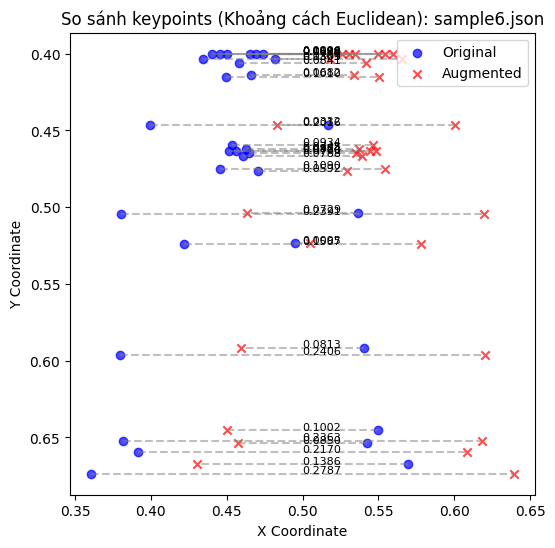


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample6.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample6.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.08414         0.00000         0.08414
left_eye_inner       0.06956         0.00000         0.06956
left_eye             0.06076         0.00000         0.06076
left_eye_outer       0.05177         0.00000         0.05177
right_eye_inner      0.09960         0.00000         0.09960
right_eye            0.10937         0.00000         0.10937
right_eye_outer      0.11892         0.00000         0.11892
left_ear             0.03633         0.00000         0.03633
right_ear            0.13090         0.00000         0.13090
mouth_left           0.06824         0.00000         0.06824
mouth_right          0.10105         0.00000         0.10105
left_shoulder        0.03318         0.00000         0.03318
right_shoulder

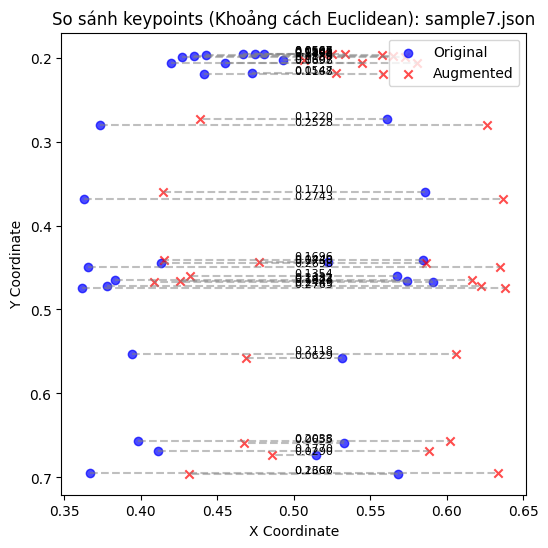


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample7.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample7.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.08976         0.00000         0.08976
left_eye_inner       0.06666         0.00000         0.06666
left_eye             0.05033         0.00000         0.05033
left_eye_outer       0.03852         0.00000         0.03852
right_eye_inner      0.11483         0.00000         0.11483
right_eye            0.13034         0.00000         0.13034
right_eye_outer      0.14594         0.00000         0.14594
left_ear             0.01389         0.00000         0.01389
right_ear            0.16066         0.00000         0.16066
mouth_left           0.05471         0.00000         0.05471
mouth_right          0.11681         0.00000         0.11681
left_shoulder        0.12201         0.00000         0.12201
right_shoulder

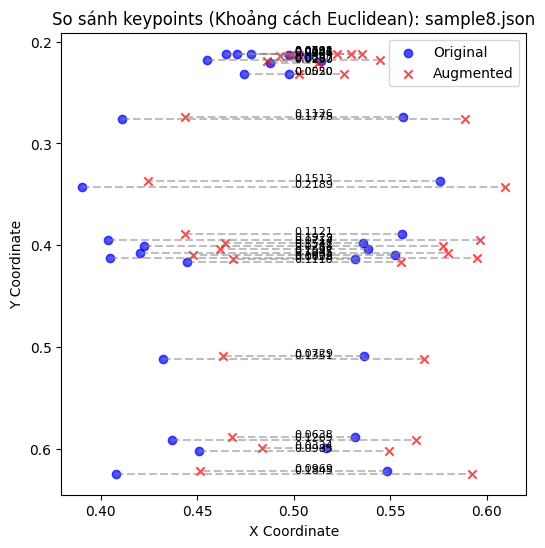


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample8.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample8.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.02495         0.00000         0.02495
left_eye_inner       0.00516         0.00000         0.00516
left_eye             0.00413         0.00000         0.00413
left_eye_outer       0.01464         0.00000         0.01464
right_eye_inner      0.04454         0.00000         0.04454
right_eye            0.05910         0.00000         0.05910
right_eye_outer      0.07044         0.00000         0.07044
left_ear             0.02822         0.00000         0.02822
right_ear            0.08972         0.00000         0.08972
mouth_left           0.00498         0.00000         0.00498
mouth_right          0.05198         0.00000         0.05198
left_shoulder        0.11265         0.00000         0.11265
right_shoulder

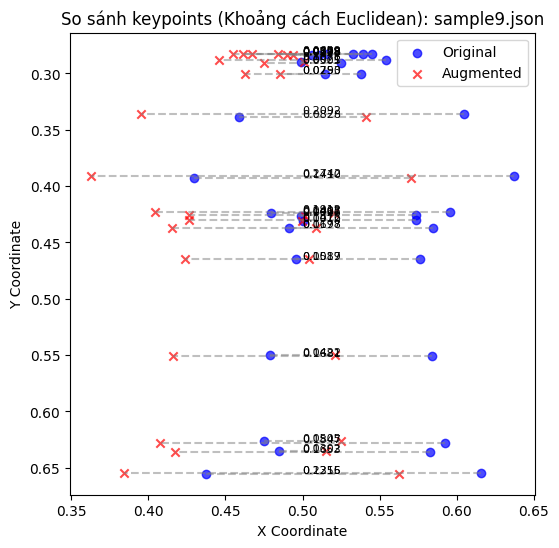


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample9.json vs data/keypoints_augmented_horizontal_flip/Garland_Pose\sample9.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.05047         0.00000         0.05047
left_eye_inner       0.06586         0.00000         0.06586
left_eye             0.07784         0.00000         0.07784
left_eye_outer       0.08977         0.00000         0.08977
right_eye_inner      0.03190         0.00000         0.03190
right_eye            0.02077         0.00000         0.02077
right_eye_outer      0.01233         0.00000         0.01233
left_ear             0.10776         0.00000         0.10776
right_ear            0.00207         0.00000         0.00207
mouth_left           0.07526         0.00000         0.07526
mouth_right          0.02895         0.00000         0.02895
left_shoulder        0.20921         0.00000         0.20921
right_shoulder

In [33]:
original_folder = "data/keypoints/Garland_Pose"
augmented_folder = "data/keypoints_augmented_horizontal_flip/Garland_Pose"

visualize_folder(original_folder, augmented_folder)


🚀 Visualizing sample1.json ...


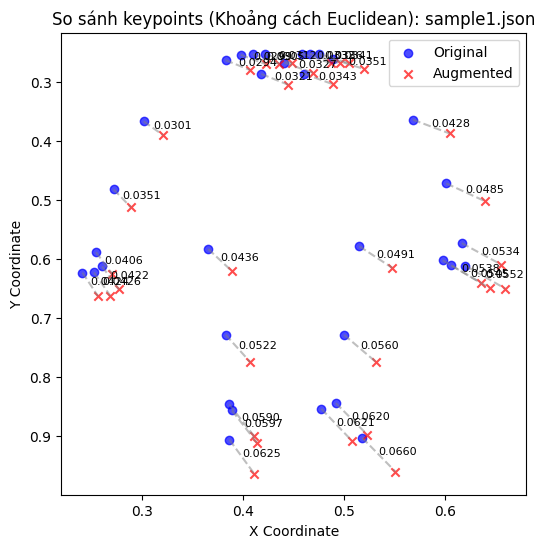


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample1.json vs data/keypoints_augmented_scaling/Garland_Pose\sample1.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.02795         0.01694         0.03269
left_eye_inner       0.02905         0.01598         0.03316
left_eye             0.02955         0.01598         0.03360
left_eye_outer       0.03013         0.01601         0.03412
right_eye_inner      0.02675         0.01600         0.03117
right_eye            0.02598         0.01602         0.03052
right_eye_outer      0.02521         0.01609         0.02991
left_ear             0.03100         0.01657         0.03515
right_ear            0.02426         0.01667         0.02943
mouth_left           0.02917         0.01812         0.03434
mouth_right          0.02650         0.01816         0.03213
left_shoulder        0.03604         0.02308         0.04280
right_shoulder       0

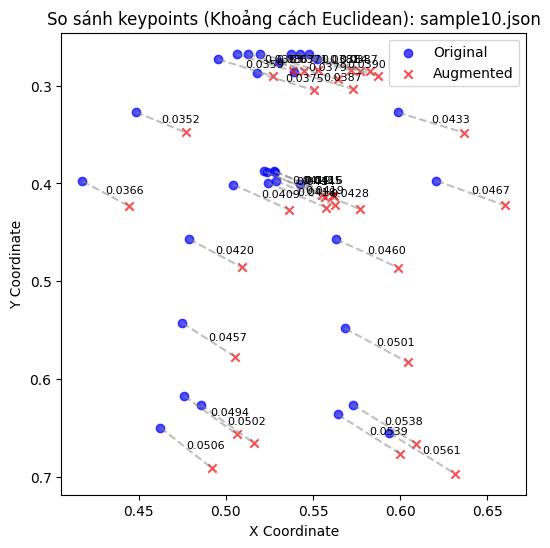


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample10.json vs data/keypoints_augmented_scaling/Garland_Pose\sample10.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.03364         0.01750         0.03792
left_eye_inner       0.03409         0.01697         0.03808
left_eye             0.03439         0.01698         0.03835
left_eye_outer       0.03473         0.01700         0.03867
right_eye_inner      0.03296         0.01696         0.03706
right_eye            0.03250         0.01697         0.03666
right_eye_outer      0.03210         0.01700         0.03632
left_ear             0.03500         0.01728         0.03903
right_ear            0.03142         0.01731         0.03588
mouth_left           0.03418         0.01811         0.03868
mouth_right          0.03283         0.01818         0.03752
left_shoulder        0.03796         0.02076         0.04327
right_shoulder      

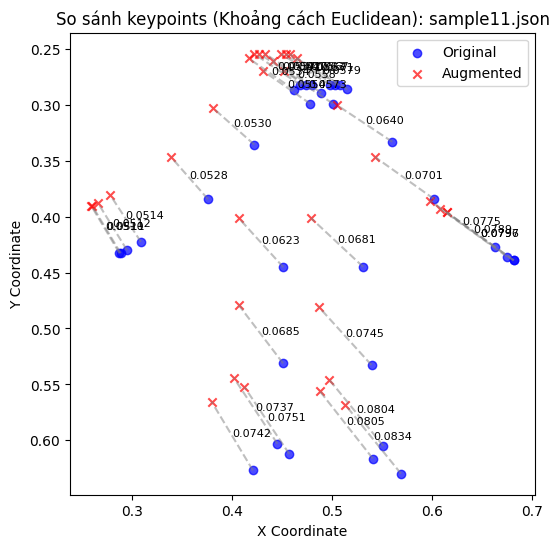


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample11.json vs data/keypoints_augmented_scaling/Garland_Pose\sample11.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.04808         0.02839         0.05583
left_eye_inner       0.04896         0.02771         0.05626
left_eye             0.04945         0.02773         0.05670
left_eye_outer       0.04992         0.02775         0.05712
right_eye_inner      0.04718         0.02768         0.05470
right_eye            0.04658         0.02768         0.05419
right_eye_outer      0.04602         0.02770         0.05371
left_ear             0.05063         0.02809         0.05790
right_ear            0.04541         0.02813         0.05342
mouth_left           0.04921         0.02935         0.05730
mouth_right          0.04701         0.02937         0.05543
left_shoulder        0.05504         0.03271         0.06403
right_shoulder      

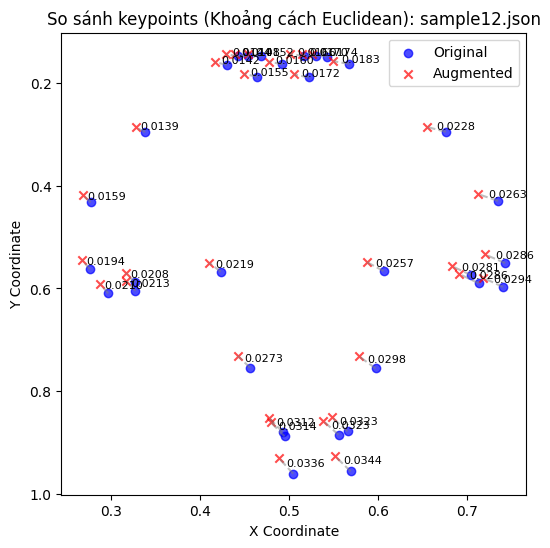


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample12.json vs data/keypoints_augmented_scaling/Garland_Pose\sample12.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01523         0.00505         0.01605
left_eye_inner       0.01598         0.00456         0.01662
left_eye             0.01641         0.00457         0.01703
left_eye_outer       0.01677         0.00458         0.01739
right_eye_inner      0.01450         0.00456         0.01520
right_eye            0.01403         0.00458         0.01476
right_eye_outer      0.01370         0.00458         0.01445
left_ear             0.01755         0.00503         0.01826
right_ear            0.01331         0.00508         0.01424
mouth_left           0.01615         0.00584         0.01718
mouth_right          0.01436         0.00581         0.01549
left_shoulder        0.02092         0.00912         0.02282
right_shoulder      

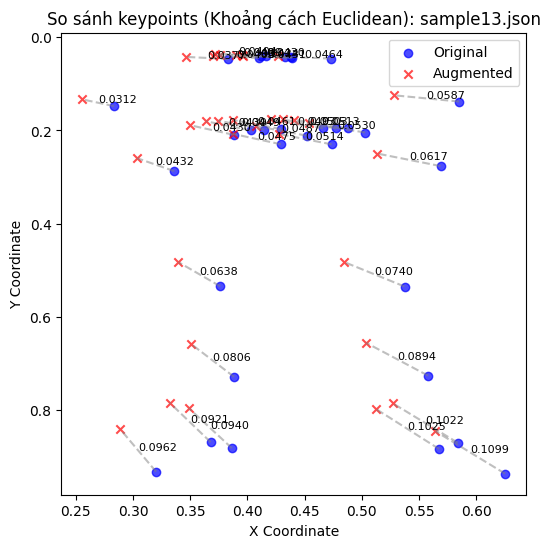


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample13.json vs data/keypoints_augmented_scaling/Garland_Pose\sample13.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.04408         0.02060         0.04866
left_eye_inner       0.04548         0.01906         0.04931
left_eye             0.04659         0.01908         0.05035
left_eye_outer       0.04765         0.01909         0.05133
right_eye_inner      0.04191         0.01921         0.04610
right_eye            0.04050         0.01935         0.04488
right_eye_outer      0.03933         0.01949         0.04389
left_ear             0.04908         0.01994         0.05298
right_ear            0.03786         0.02042         0.04302
mouth_left           0.04623         0.02243         0.05139
mouth_right          0.04189         0.02241         0.04751
left_shoulder        0.05551         0.02697         0.06172
right_shoulder      

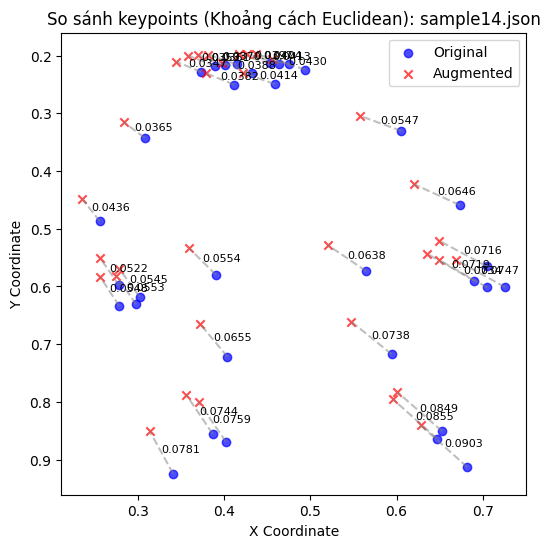


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample14.json vs data/keypoints_augmented_scaling/Garland_Pose\sample14.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.03423         0.01825         0.03879
left_eye_inner       0.03585         0.01693         0.03965
left_eye             0.03669         0.01695         0.04041
left_eye_outer       0.03763         0.01700         0.04129
right_eye_inner      0.03282         0.01706         0.03699
right_eye            0.03177         0.01714         0.03610
right_eye_outer      0.03082         0.01723         0.03531
left_ear             0.03914         0.01776         0.04299
right_ear            0.02959         0.01810         0.03469
mouth_left           0.03634         0.01977         0.04137
mouth_right          0.03260         0.01984         0.03816
left_shoulder        0.04798         0.02619         0.05466
right_shoulder      

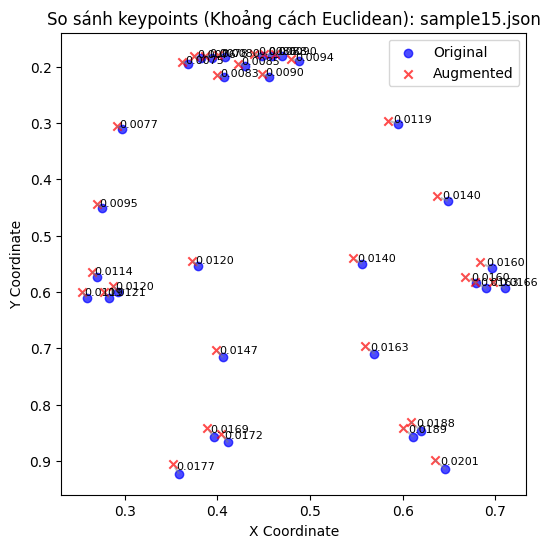


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample15.json vs data/keypoints_augmented_scaling/Garland_Pose\sample15.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00770         0.00355         0.00847
left_eye_inner       0.00802         0.00323         0.00864
left_eye             0.00821         0.00323         0.00882
left_eye_outer       0.00842         0.00323         0.00902
right_eye_inner      0.00731         0.00327         0.00800
right_eye            0.00706         0.00329         0.00779
right_eye_outer      0.00684         0.00332         0.00760
left_ear             0.00875         0.00340         0.00938
right_ear            0.00659         0.00349         0.00746
mouth_left           0.00816         0.00389         0.00904
mouth_right          0.00729         0.00392         0.00828
left_shoulder        0.01065         0.00539         0.01193
right_shoulder      

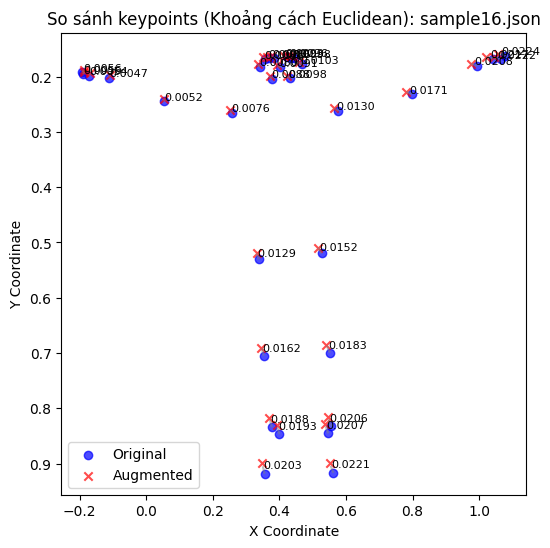


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample16.json vs data/keypoints_augmented_scaling/Garland_Pose\sample16.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00828         0.00377         0.00910
left_eye_inner       0.00870         0.00340         0.00934
left_eye             0.00894         0.00341         0.00957
left_eye_outer       0.00913         0.00342         0.00975
right_eye_inner      0.00788         0.00343         0.00859
right_eye            0.00761         0.00344         0.00835
right_eye_outer      0.00735         0.00346         0.00813
left_ear             0.00962         0.00366         0.01030
right_ear            0.00703         0.00374         0.00796
mouth_left           0.00886         0.00417         0.00979
mouth_right          0.00778         0.00419         0.00884
left_shoulder        0.01187         0.00540         0.01304
right_shoulder      

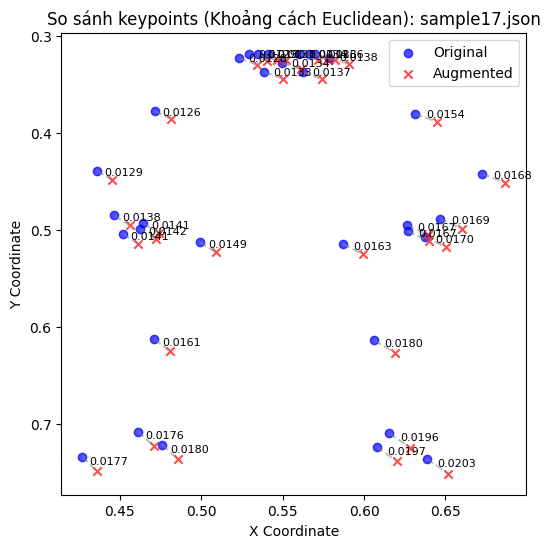


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample17.json vs data/keypoints_augmented_scaling/Garland_Pose\sample17.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01147         0.00684         0.01336
left_eye_inner       0.01169         0.00665         0.01345
left_eye             0.01181         0.00665         0.01356
left_eye_outer       0.01190         0.00665         0.01363
right_eye_inner      0.01129         0.00665         0.01310
right_eye            0.01117         0.00665         0.01300
right_eye_outer      0.01105         0.00666         0.01290
left_ear             0.01208         0.00673         0.01383
right_ear            0.01092         0.00674         0.01283
mouth_left           0.01174         0.00704         0.01369
mouth_right          0.01125         0.00704         0.01327
left_shoulder        0.01318         0.00794         0.01538
right_shoulder      

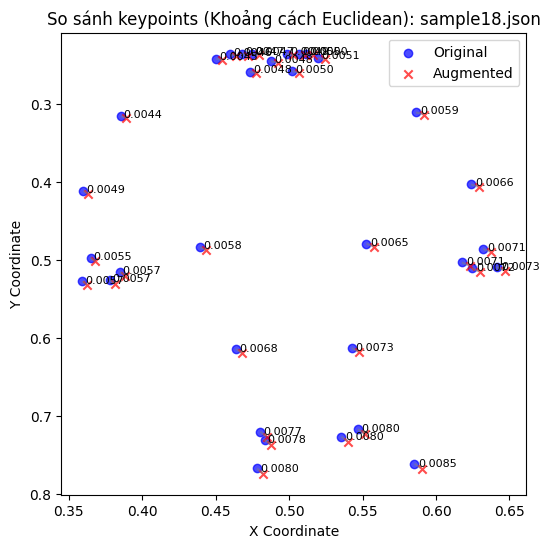


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample18.json vs data/keypoints_augmented_scaling/Garland_Pose\sample18.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00433         0.00218         0.00485
left_eye_inner       0.00442         0.00209         0.00489
left_eye             0.00450         0.00209         0.00496
left_eye_outer       0.00454         0.00209         0.00500
right_eye_inner      0.00422         0.00209         0.00471
right_eye            0.00415         0.00209         0.00465
right_eye_outer      0.00408         0.00210         0.00459
left_ear             0.00461         0.00214         0.00508
right_ear            0.00400         0.00215         0.00454
mouth_left           0.00446         0.00229         0.00501
mouth_right          0.00420         0.00229         0.00479
left_shoulder        0.00521         0.00276         0.00589
right_shoulder      

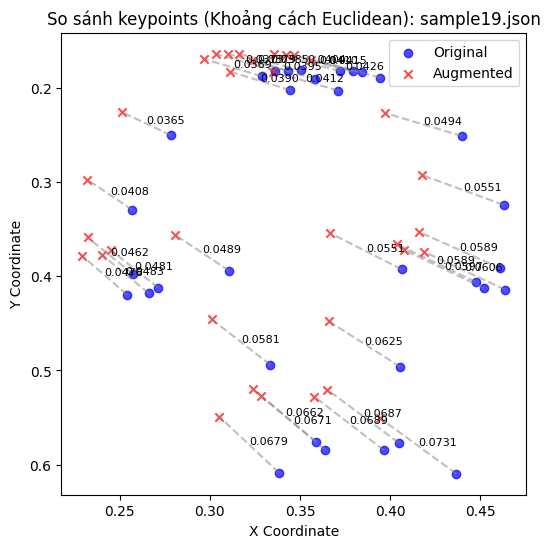


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample19.json vs data/keypoints_augmented_scaling/Garland_Pose\sample19.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.03493         0.01853         0.03955
left_eye_inner       0.03628         0.01775         0.04039
left_eye             0.03698         0.01780         0.04104
left_eye_outer       0.03748         0.01786         0.04152
right_eye_inner      0.03416         0.01769         0.03847
right_eye            0.03347         0.01770         0.03787
right_eye_outer      0.03279         0.01773         0.03728
left_ear             0.03846         0.01843         0.04265
right_ear            0.03206         0.01829         0.03690
mouth_left           0.03620         0.01978         0.04125
mouth_right          0.03361         0.01974         0.03898
left_shoulder        0.04290         0.02448         0.04940
right_shoulder      

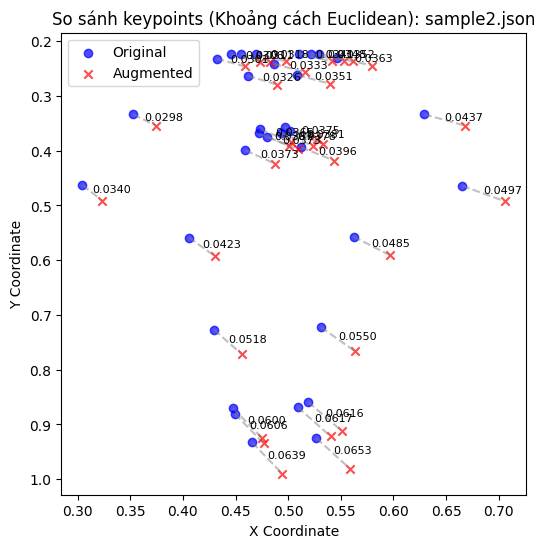


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample2.json vs data/keypoints_augmented_scaling/Garland_Pose\sample2.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.02981         0.01482         0.03329
left_eye_inner       0.03126         0.01367         0.03412
left_eye             0.03197         0.01367         0.03477
left_eye_outer       0.03245         0.01369         0.03522
right_eye_inner      0.02875         0.01369         0.03185
right_eye            0.02791         0.01372         0.03110
right_eye_outer      0.02734         0.01376         0.03061
left_ear             0.03349         0.01413         0.03634
right_ear            0.02649         0.01422         0.03006
mouth_left           0.03119         0.01606         0.03508
mouth_right          0.02829         0.01614         0.03257
left_shoulder        0.03858         0.02046         0.04367
right_shoulder       0

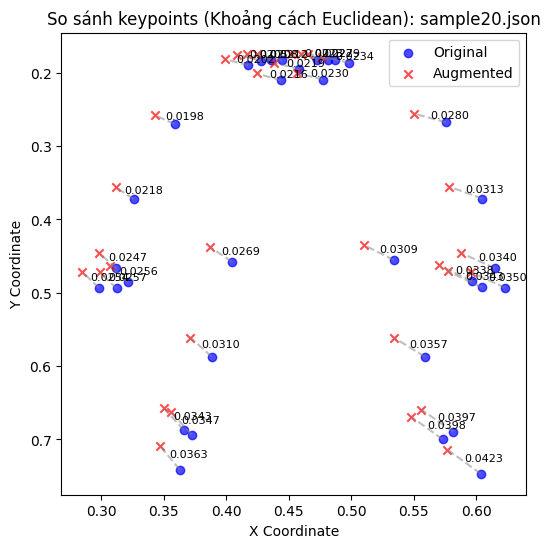


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample20.json vs data/keypoints_augmented_scaling/Garland_Pose\sample20.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.02019         0.00859         0.02194
left_eye_inner       0.02083         0.00802         0.02232
left_eye             0.02119         0.00802         0.02266
left_eye_outer       0.02145         0.00803         0.02290
right_eye_inner      0.01957         0.00805         0.02116
right_eye            0.01921         0.00806         0.02083
right_eye_outer      0.01883         0.00808         0.02049
left_ear             0.02196         0.00821         0.02344
right_ear            0.01839         0.00836         0.02020
mouth_left           0.02102         0.00922         0.02296
mouth_right          0.01955         0.00926         0.02163
left_shoulder        0.02535         0.01178         0.02796
right_shoulder      

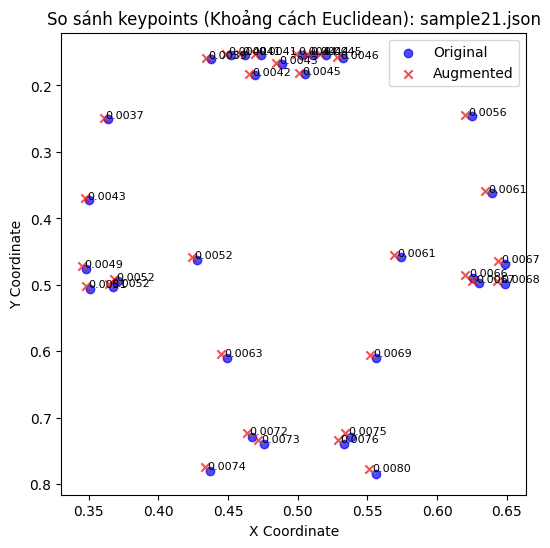


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample21.json vs data/keypoints_augmented_scaling/Garland_Pose\sample21.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00407         0.00140         0.00430
left_eye_inner       0.00419         0.00128         0.00438
left_eye             0.00426         0.00128         0.00445
left_eye_outer       0.00434         0.00128         0.00452
right_eye_inner      0.00394         0.00128         0.00415
right_eye            0.00385         0.00128         0.00406
right_eye_outer      0.00377         0.00128         0.00398
left_ear             0.00444         0.00133         0.00463
right_ear            0.00365         0.00133         0.00388
mouth_left           0.00421         0.00153         0.00448
mouth_right          0.00391         0.00154         0.00420
left_shoulder        0.00520         0.00205         0.00559
right_shoulder      

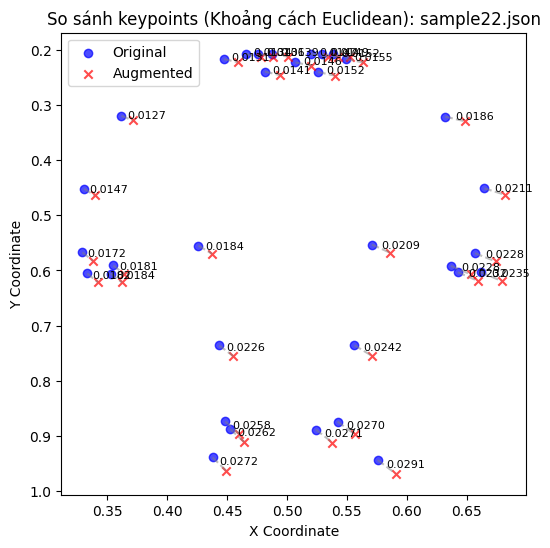


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample22.json vs data/keypoints_augmented_scaling/Garland_Pose\sample22.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01332         0.00585         0.01455
left_eye_inner       0.01367         0.00545         0.01472
left_eye             0.01390         0.00546         0.01494
left_eye_outer       0.01414         0.00547         0.01516
right_eye_inner      0.01282         0.00544         0.01393
right_eye            0.01251         0.00544         0.01364
right_eye_outer      0.01224         0.00546         0.01340
left_ear             0.01443         0.00570         0.01552
right_ear            0.01176         0.00570         0.01306
mouth_left           0.01382         0.00631         0.01519
mouth_right          0.01265         0.00629         0.01413
left_shoulder        0.01661         0.00844         0.01863
right_shoulder      

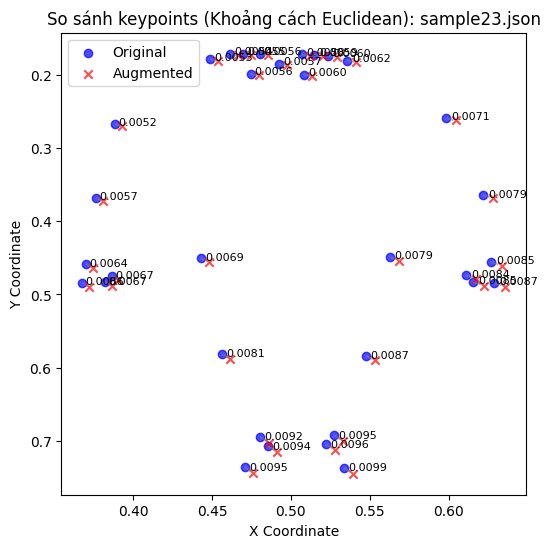


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample23.json vs data/keypoints_augmented_scaling/Garland_Pose\sample23.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00537         0.00202         0.00574
left_eye_inner       0.00553         0.00188         0.00584
left_eye             0.00562         0.00188         0.00593
left_eye_outer       0.00572         0.00189         0.00602
right_eye_inner      0.00524         0.00187         0.00556
right_eye            0.00513         0.00187         0.00546
right_eye_outer      0.00504         0.00187         0.00537
left_ear             0.00585         0.00197         0.00617
right_ear            0.00490         0.00195         0.00527
mouth_left           0.00555         0.00218         0.00596
mouth_right          0.00518         0.00217         0.00561
left_shoulder        0.00653         0.00283         0.00712
right_shoulder      

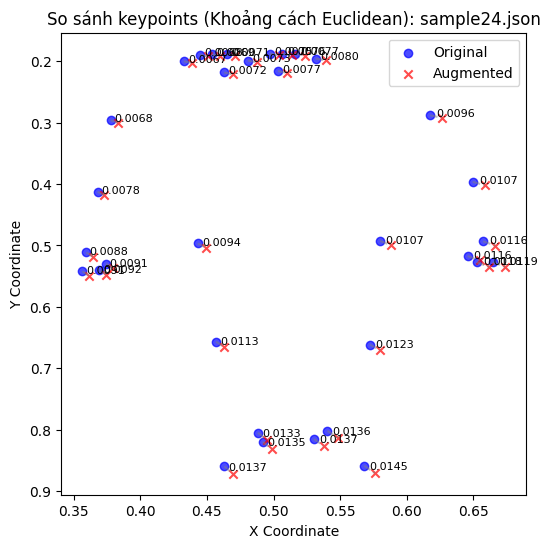


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample24.json vs data/keypoints_augmented_scaling/Garland_Pose\sample24.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00677         0.00280         0.00732
left_eye_inner       0.00700         0.00264         0.00748
left_eye             0.00713         0.00264         0.00761
left_eye_outer       0.00727         0.00265         0.00774
right_eye_inner      0.00654         0.00265         0.00706
right_eye            0.00639         0.00266         0.00692
right_eye_outer      0.00626         0.00267         0.00681
left_ear             0.00748         0.00275         0.00798
right_ear            0.00609         0.00282         0.00671
mouth_left           0.00709         0.00304         0.00771
mouth_right          0.00652         0.00307         0.00721
left_shoulder        0.00869         0.00405         0.00959
right_shoulder      

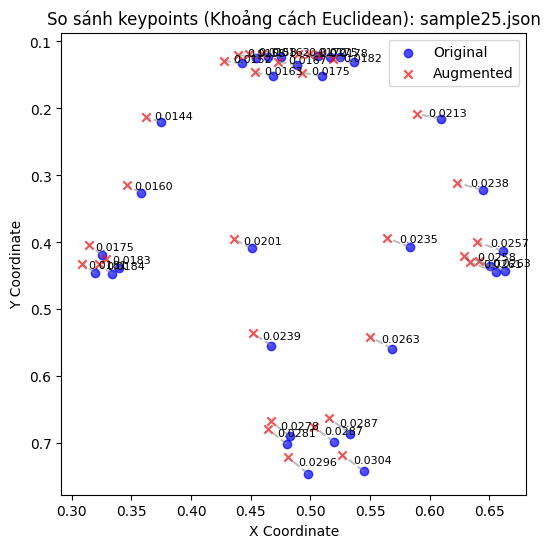


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample25.json vs data/keypoints_augmented_scaling/Garland_Pose\sample25.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01614         0.00445         0.01674
left_eye_inner       0.01672         0.00404         0.01720
left_eye             0.01703         0.00406         0.01750
left_eye_outer       0.01731         0.00408         0.01778
right_eye_inner      0.01567         0.00404         0.01618
right_eye            0.01532         0.00406         0.01585
right_eye_outer      0.01500         0.00409         0.01554
left_ear             0.01770         0.00433         0.01823
right_ear            0.01459         0.00439         0.01524
mouth_left           0.01681         0.00500         0.01754
mouth_right          0.01547         0.00499         0.01626
left_shoulder        0.02010         0.00710         0.02131
right_shoulder      

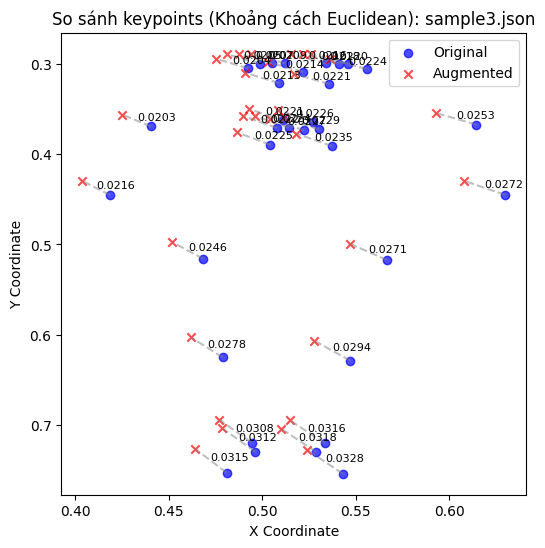


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample3.json vs data/keypoints_augmented_scaling/Garland_Pose\sample3.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01842         0.01091         0.02141
left_eye_inner       0.01886         0.01057         0.02162
left_eye             0.01910         0.01058         0.02183
left_eye_outer       0.01926         0.01058         0.02198
right_eye_inner      0.01809         0.01056         0.02094
right_eye            0.01784         0.01056         0.02074
right_eye_outer      0.01760         0.01057         0.02053
left_ear             0.01962         0.01078         0.02239
right_ear            0.01739         0.01076         0.02045
mouth_left           0.01892         0.01138         0.02208
mouth_right          0.01797         0.01134         0.02125
left_shoulder        0.02169         0.01296         0.02527
right_shoulder       0

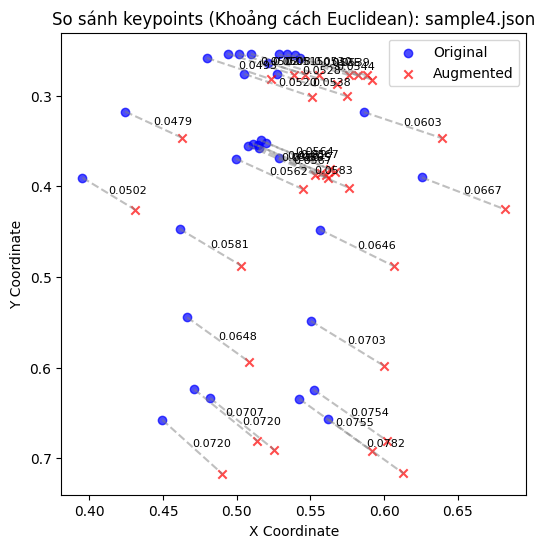


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample4.json vs data/keypoints_augmented_scaling/Garland_Pose\sample4.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.04710         0.02384         0.05279
left_eye_inner       0.04777         0.02299         0.05301
left_eye             0.04829         0.02300         0.05349
left_eye_outer       0.04878         0.02303         0.05394
right_eye_inner      0.04608         0.02295         0.05148
right_eye            0.04532         0.02294         0.05080
right_eye_outer      0.04465         0.02294         0.05020
left_ear             0.04909         0.02340         0.05438
right_ear            0.04336         0.02336         0.04925
mouth_left           0.04768         0.02493         0.05380
mouth_right          0.04567         0.02496         0.05205
left_shoulder        0.05302         0.02877         0.06032
right_shoulder       0

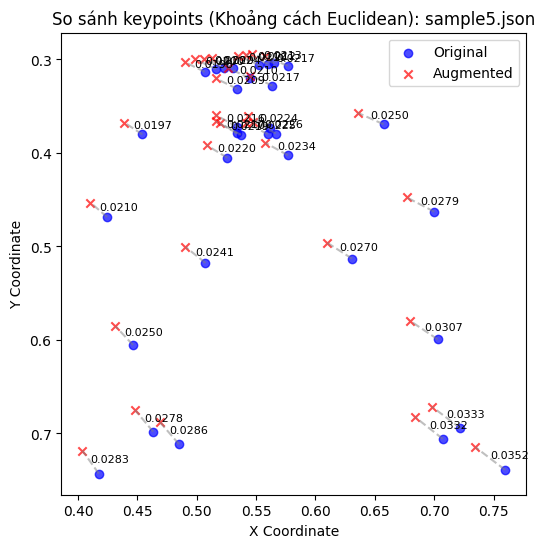


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample5.json vs data/keypoints_augmented_scaling/Garland_Pose\sample5.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01809         0.01062         0.02097
left_eye_inner       0.01836         0.01016         0.02098
left_eye             0.01860         0.01012         0.02118
left_eye_outer       0.01877         0.01009         0.02131
right_eye_inner      0.01761         0.01026         0.02038
right_eye            0.01737         0.01028         0.02018
right_eye_outer      0.01714         0.01030         0.02000
left_ear             0.01915         0.01019         0.02169
right_ear            0.01683         0.01040         0.01978
mouth_left           0.01872         0.01089         0.02166
mouth_right          0.01773         0.01100         0.02087
left_shoulder        0.02183         0.01226         0.02504
right_shoulder       0

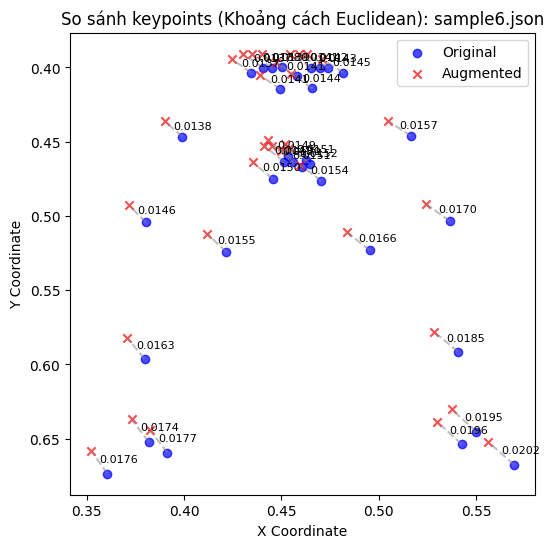


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample6.json vs data/keypoints_augmented_scaling/Garland_Pose\sample6.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01056         0.00936         0.01411
left_eye_inner       0.01072         0.00923         0.01415
left_eye             0.01083         0.00922         0.01422
left_eye_outer       0.01093         0.00923         0.01430
right_eye_inner      0.01038         0.00922         0.01388
right_eye            0.01027         0.00922         0.01380
right_eye_outer      0.01016         0.00923         0.01372
left_ear             0.01111         0.00930         0.01449
right_ear            0.01002         0.00931         0.01367
mouth_left           0.01074         0.00955         0.01437
mouth_right          0.01036         0.00956         0.01410
left_shoulder        0.01191         0.01029         0.01574
right_shoulder       0

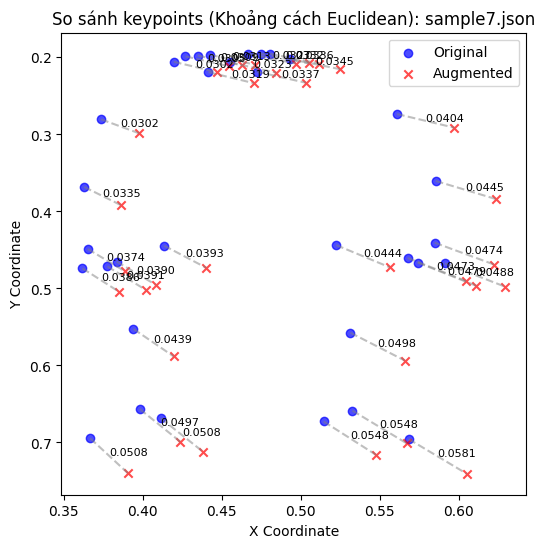


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample7.json vs data/keypoints_augmented_scaling/Garland_Pose\sample7.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.02945         0.01337         0.03234
left_eye_inner       0.03020         0.01264         0.03274
left_eye             0.03072         0.01264         0.03322
left_eye_outer       0.03111         0.01265         0.03358
right_eye_inner      0.02864         0.01274         0.03134
right_eye            0.02814         0.01280         0.03091
right_eye_outer      0.02763         0.01286         0.03048
left_ear             0.03190         0.01309         0.03448
right_ear            0.02715         0.01332         0.03025
mouth_left           0.03058         0.01416         0.03370
mouth_right          0.02857         0.01419         0.03190
left_shoulder        0.03630         0.01771         0.04039
right_shoulder       0

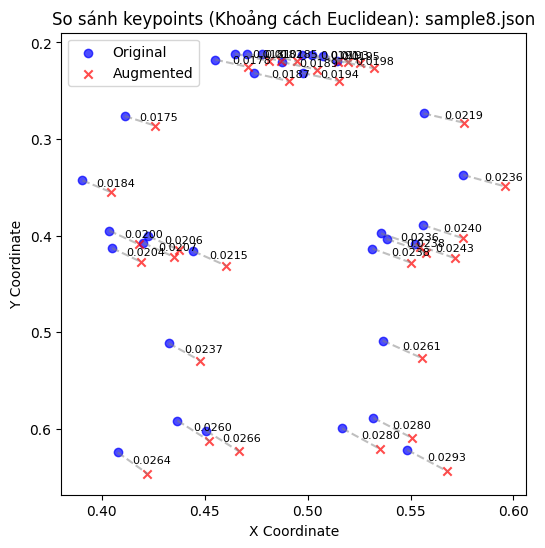


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample8.json vs data/keypoints_augmented_scaling/Garland_Pose\sample8.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01723         0.00779         0.01891
left_eye_inner       0.01758         0.00752         0.01912
left_eye             0.01774         0.00754         0.01928
left_eye_outer       0.01793         0.00755         0.01946
right_eye_inner      0.01688         0.00749         0.01847
right_eye            0.01663         0.00749         0.01823
right_eye_outer      0.01643         0.00748         0.01805
left_ear             0.01817         0.00774         0.01975
right_ear            0.01609         0.00770         0.01783
mouth_left           0.01758         0.00819         0.01940
mouth_right          0.01675         0.00820         0.01865
left_shoulder        0.01966         0.00967         0.02191
right_shoulder       0

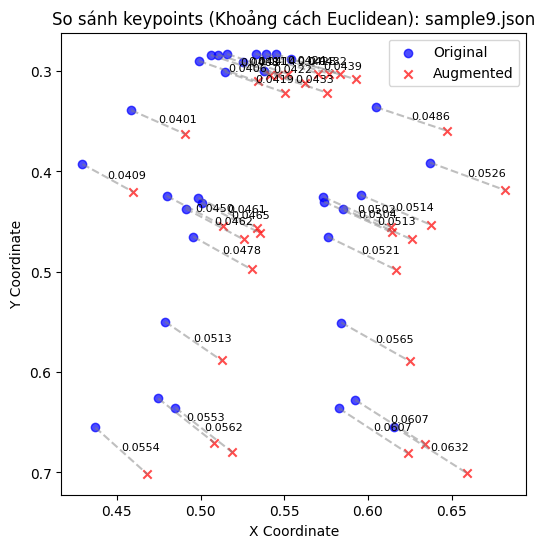


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample9.json vs data/keypoints_augmented_scaling/Garland_Pose\sample9.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.03694         0.02048         0.04224
left_eye_inner       0.03748         0.01988         0.04242
left_eye             0.03790         0.01989         0.04280
left_eye_outer       0.03832         0.01990         0.04318
right_eye_inner      0.03629         0.01990         0.04138
right_eye            0.03590         0.01993         0.04106
right_eye_outer      0.03560         0.01997         0.04082
left_ear             0.03895         0.02026         0.04391
right_ear            0.03509         0.02038         0.04058
mouth_left           0.03781         0.02112         0.04331
mouth_right          0.03618         0.02113         0.04190
left_shoulder        0.04252         0.02362         0.04864
right_shoulder       0

In [34]:
original_folder = "data/keypoints/Garland_Pose"
augmented_folder = "data/keypoints_augmented_scaling/Garland_Pose"

visualize_folder(original_folder, augmented_folder)


🚀 Visualizing sample1.json ...


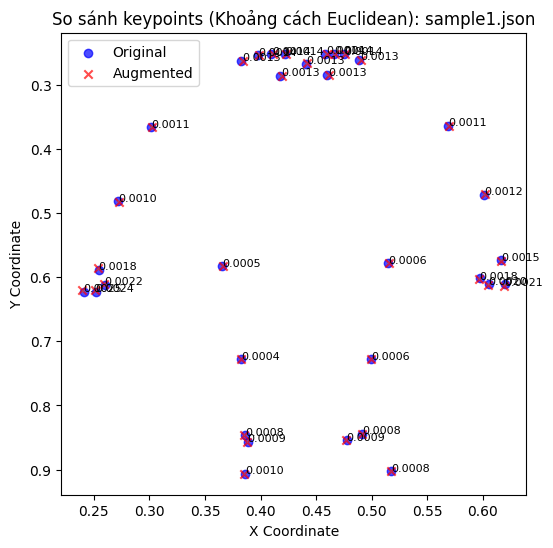


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample1.json vs data/keypoints_augmented_rotation/Garland_Pose\sample1.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00134         0.00011         0.00135
left_eye_inner       0.00136         0.00008         0.00136
left_eye             0.00136         0.00009         0.00136
left_eye_outer       0.00136         0.00008         0.00136
right_eye_inner      0.00136         0.00013         0.00136
right_eye            0.00136         0.00013         0.00136
right_eye_outer      0.00135         0.00016         0.00136
left_ear             0.00133         0.00006         0.00133
right_ear            0.00132         0.00017         0.00133
mouth_left           0.00132         0.00010         0.00132
mouth_right          0.00133         0.00013         0.00133
left_shoulder        0.00110         0.00002         0.00110
right_shoulder       

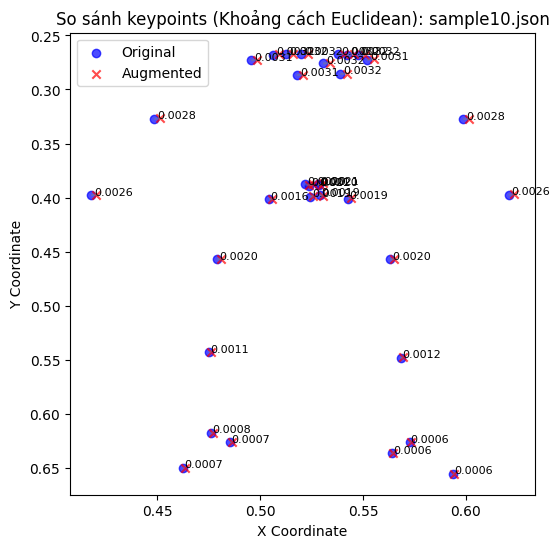


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample10.json vs data/keypoints_augmented_rotation/Garland_Pose\sample10.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00319         0.00037         0.00321
left_eye_inner       0.00318         0.00046         0.00322
left_eye             0.00318         0.00049         0.00321
left_eye_outer       0.00317         0.00046         0.00320
right_eye_inner      0.00317         0.00050         0.00321
right_eye            0.00314         0.00053         0.00319
right_eye_outer      0.00312         0.00051         0.00316
left_ear             0.00310         0.00055         0.00315
right_ear            0.00301         0.00053         0.00306
mouth_left           0.00317         0.00034         0.00319
mouth_right          0.00311         0.00036         0.00313
left_shoulder        0.00277         0.00022         0.00278
right_shoulder     

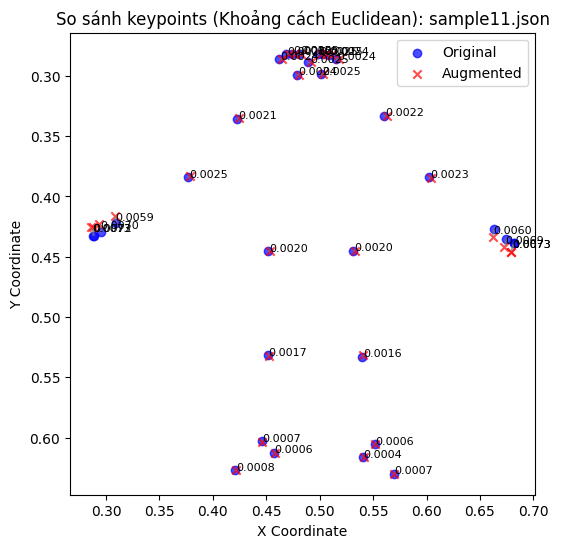


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample11.json vs data/keypoints_augmented_rotation/Garland_Pose\sample11.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00251         0.00001         0.00251
left_eye_inner       0.00246         0.00001         0.00246
left_eye             0.00245         0.00003         0.00245
left_eye_outer       0.00245         0.00003         0.00245
right_eye_inner      0.00248         0.00006         0.00248
right_eye            0.00248         0.00007         0.00248
right_eye_outer      0.00248         0.00009         0.00248
left_ear             0.00241         0.00006         0.00241
right_ear            0.00241         0.00005         0.00241
mouth_left           0.00245         0.00004         0.00245
mouth_right          0.00245         0.00000         0.00245
left_shoulder        0.00224         0.00013         0.00224
right_shoulder     

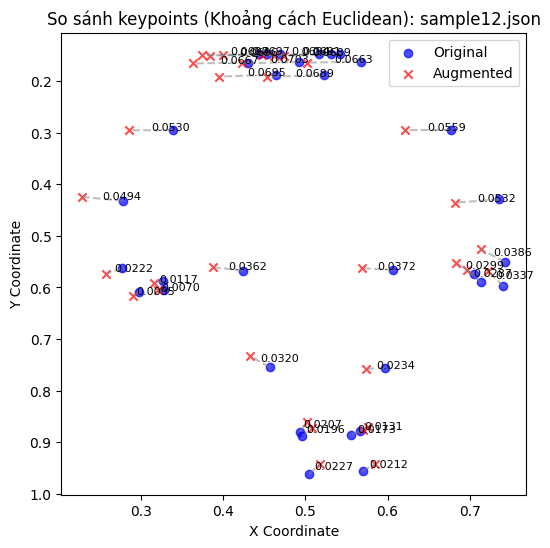


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample12.json vs data/keypoints_augmented_rotation/Garland_Pose\sample12.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.07028         0.00281         0.07034
left_eye_inner       0.06939         0.00251         0.06943
left_eye             0.06909         0.00286         0.06915
left_eye_outer       0.06885         0.00325         0.06893
right_eye_inner      0.06964         0.00283         0.06969
right_eye            0.06950         0.00301         0.06957
right_eye_outer      0.06963         0.00253         0.06968
left_ear             0.06622         0.00220         0.06626
right_ear            0.06672         0.00178         0.06675
mouth_left           0.06887         0.00296         0.06893
mouth_right          0.06938         0.00375         0.06948
left_shoulder        0.05591         0.00032         0.05591
right_shoulder     

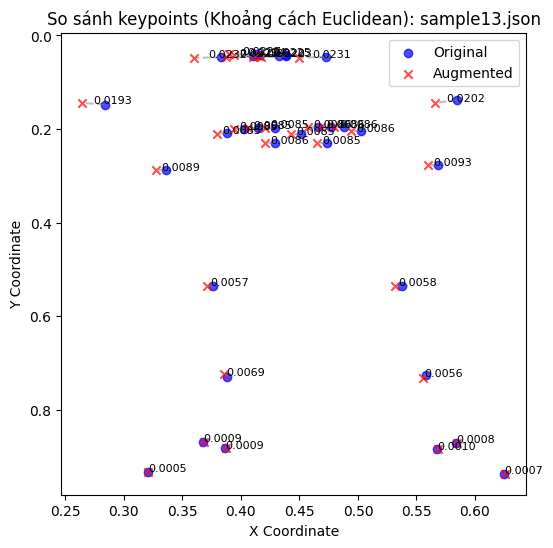


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample13.json vs data/keypoints_augmented_rotation/Garland_Pose\sample13.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00852         0.00020         0.00852
left_eye_inner       0.00857         0.00000         0.00857
left_eye             0.00857         0.00002         0.00857
left_eye_outer       0.00857         0.00006         0.00857
right_eye_inner      0.00854         0.00000         0.00854
right_eye            0.00851         0.00014         0.00851
right_eye_outer      0.00848         0.00024         0.00848
left_ear             0.00858         0.00011         0.00858
right_ear            0.00853         0.00051         0.00854
mouth_left           0.00850         0.00003         0.00850
mouth_right          0.00858         0.00008         0.00858
left_shoulder        0.00915         0.00139         0.00926
right_shoulder     

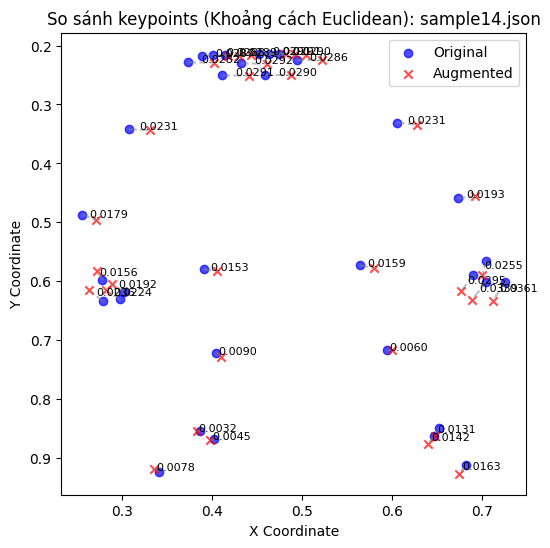


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample14.json vs data/keypoints_augmented_rotation/Garland_Pose\sample14.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.02918         0.00010         0.02918
left_eye_inner       0.02914         0.00046         0.02915
left_eye             0.02912         0.00027         0.02912
left_eye_outer       0.02898         0.00060         0.02899
right_eye_inner      0.02893         0.00052         0.02893
right_eye            0.02882         0.00053         0.02882
right_eye_outer      0.02871         0.00045         0.02872
left_ear             0.02855         0.00084         0.02857
right_ear            0.02820         0.00048         0.02821
mouth_left           0.02898         0.00072         0.02899
mouth_right          0.02905         0.00073         0.02906
left_shoulder        0.02277         0.00376         0.02308
right_shoulder     

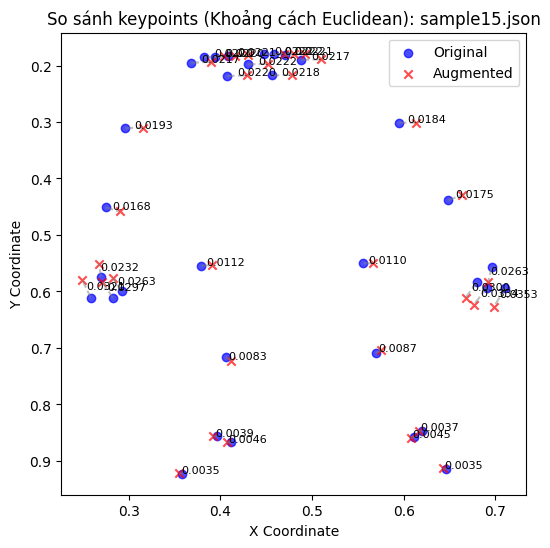


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample15.json vs data/keypoints_augmented_rotation/Garland_Pose\sample15.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.02215         0.00141         0.02220
left_eye_inner       0.02217         0.00125         0.02220
left_eye             0.02213         0.00127         0.02216
left_eye_outer       0.02206         0.00102         0.02208
right_eye_inner      0.02206         0.00140         0.02211
right_eye            0.02195         0.00148         0.02200
right_eye_outer      0.02188         0.00173         0.02195
left_ear             0.02165         0.00084         0.02167
right_ear            0.02162         0.00159         0.02168
mouth_left           0.02178         0.00102         0.02180
mouth_right          0.02199         0.00152         0.02204
left_shoulder        0.01840         0.00020         0.01840
right_shoulder     

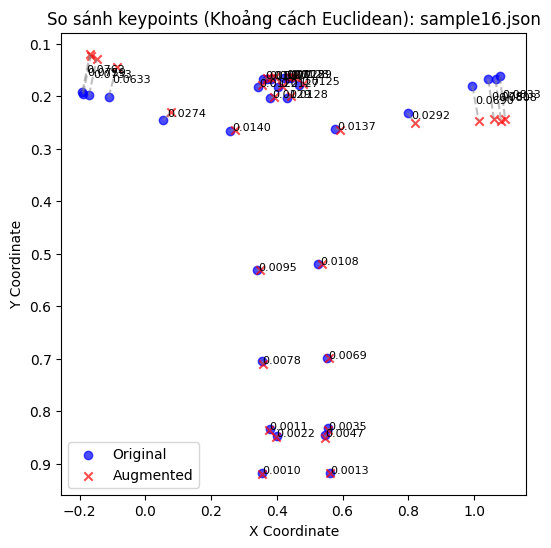


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample16.json vs data/keypoints_augmented_rotation/Garland_Pose\sample16.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01245         0.00274         0.01275
left_eye_inner       0.01257         0.00236         0.01279
left_eye             0.01257         0.00238         0.01279
left_eye_outer       0.01261         0.00262         0.01288
right_eye_inner      0.01246         0.00263         0.01274
right_eye            0.01247         0.00256         0.01273
right_eye_outer      0.01245         0.00248         0.01269
left_ear             0.01236         0.00163         0.01246
right_ear            0.01201         0.00215         0.01221
mouth_left           0.01262         0.00196         0.01278
mouth_right          0.01258         0.00283         0.01290
left_shoulder        0.01363         0.00164         0.01373
right_shoulder     

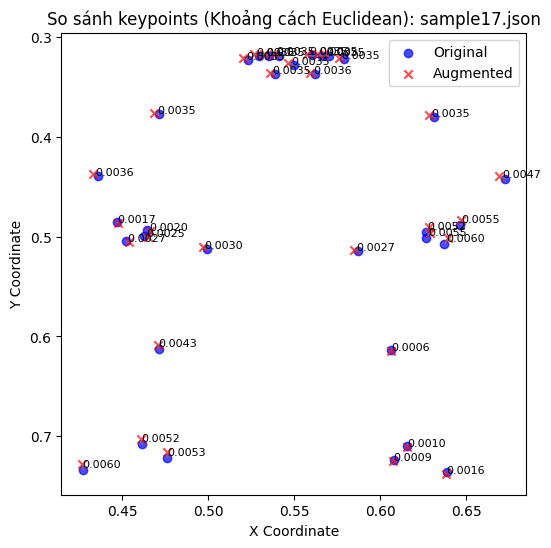


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample17.json vs data/keypoints_augmented_rotation/Garland_Pose\sample17.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00305         0.00175         0.00352
left_eye_inner       0.00304         0.00176         0.00351
left_eye             0.00303         0.00176         0.00351
left_eye_outer       0.00303         0.00168         0.00347
right_eye_inner      0.00304         0.00174         0.00350
right_eye            0.00303         0.00178         0.00351
right_eye_outer      0.00303         0.00179         0.00352
left_ear             0.00305         0.00166         0.00348
right_ear            0.00301         0.00187         0.00354
mouth_left           0.00306         0.00182         0.00356
mouth_right          0.00306         0.00177         0.00354
left_shoulder        0.00294         0.00188         0.00349
right_shoulder     

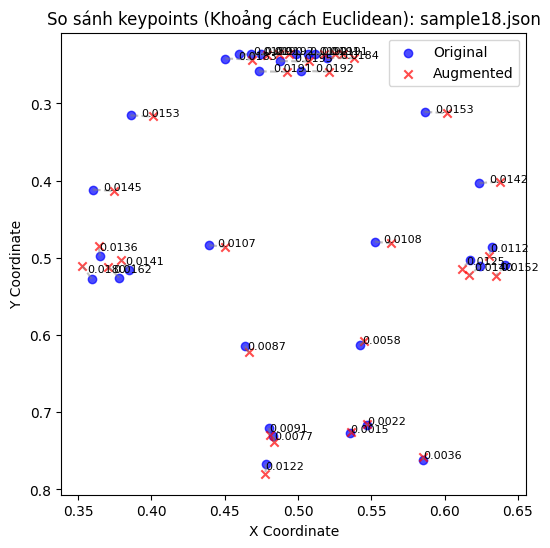


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample18.json vs data/keypoints_augmented_rotation/Garland_Pose\sample18.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01947         0.00053         0.01947
left_eye_inner       0.01917         0.00062         0.01918
left_eye             0.01908         0.00088         0.01910
left_eye_outer       0.01904         0.00075         0.01905
right_eye_inner      0.01916         0.00038         0.01916
right_eye            0.01903         0.00055         0.01904
right_eye_outer      0.01892         0.00058         0.01893
left_ear             0.01841         0.00080         0.01843
right_ear            0.01824         0.00132         0.01829
mouth_left           0.01913         0.00095         0.01915
mouth_right          0.01909         0.00056         0.01910
left_shoulder        0.01521         0.00167         0.01531
right_shoulder     

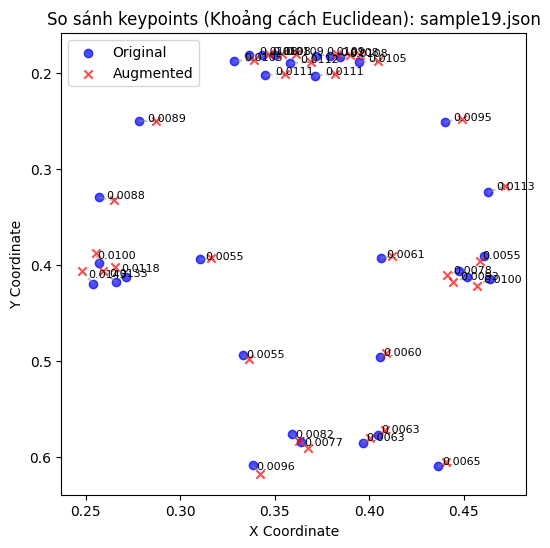


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample19.json vs data/keypoints_augmented_rotation/Garland_Pose\sample19.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01107         0.00171         0.01120
left_eye_inner       0.01076         0.00156         0.01087
left_eye             0.01069         0.00156         0.01080
left_eye_outer       0.01064         0.00175         0.01078
right_eye_inner      0.01081         0.00127         0.01089
right_eye            0.01078         0.00121         0.01085
right_eye_outer      0.01075         0.00124         0.01082
left_ear             0.01035         0.00175         0.01049
right_ear            0.01046         0.00074         0.01048
mouth_left           0.01099         0.00174         0.01113
mouth_right          0.01096         0.00167         0.01109
left_shoulder        0.00905         0.00289         0.00950
right_shoulder     

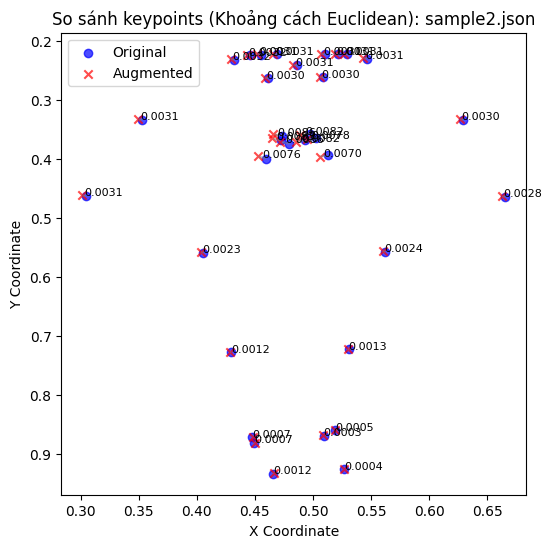


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample2.json vs data/keypoints_augmented_rotation/Garland_Pose\sample2.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00297         0.00077         0.00307
left_eye_inner       0.00300         0.00094         0.00314
left_eye             0.00299         0.00096         0.00315
left_eye_outer       0.00298         0.00089         0.00312
right_eye_inner      0.00301         0.00087         0.00314
right_eye            0.00302         0.00084         0.00313
right_eye_outer      0.00302         0.00095         0.00316
left_ear             0.00296         0.00097         0.00311
right_ear            0.00301         0.00098         0.00317
mouth_left           0.00291         0.00080         0.00302
mouth_right          0.00295         0.00074         0.00304
left_shoulder        0.00287         0.00091         0.00301
right_shoulder       

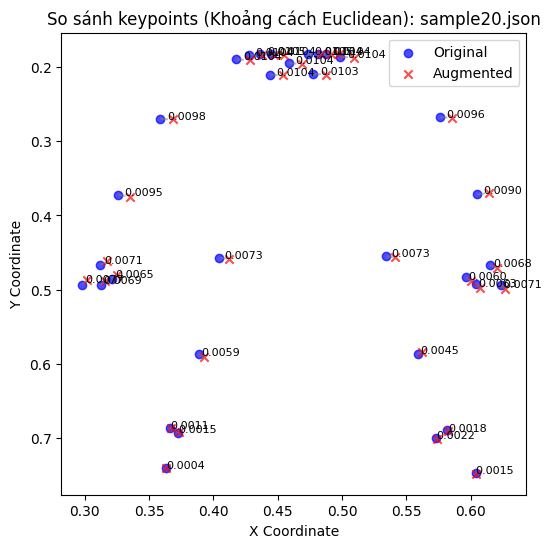


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample20.json vs data/keypoints_augmented_rotation/Garland_Pose\sample20.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01038         0.00084         0.01042
left_eye_inner       0.01041         0.00091         0.01045
left_eye             0.01041         0.00089         0.01044
left_eye_outer       0.01041         0.00080         0.01044
right_eye_inner      0.01041         0.00085         0.01045
right_eye            0.01041         0.00089         0.01045
right_eye_outer      0.01040         0.00085         0.01043
left_ear             0.01041         0.00079         0.01044
right_ear            0.01036         0.00084         0.01040
mouth_left           0.01031         0.00088         0.01035
mouth_right          0.01032         0.00087         0.01036
left_shoulder        0.00957         0.00099         0.00962
right_shoulder     

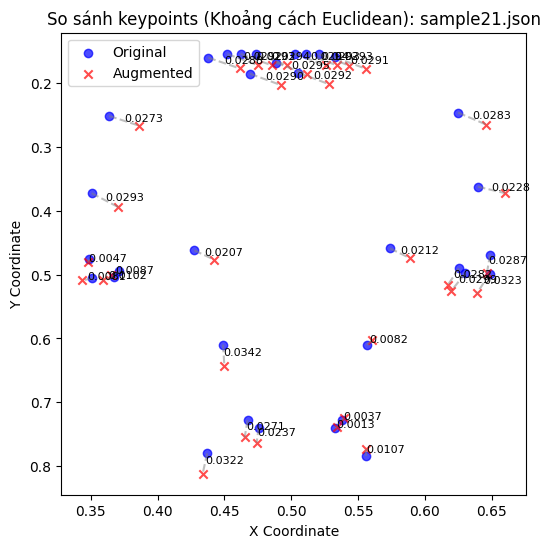


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample21.json vs data/keypoints_augmented_rotation/Garland_Pose\sample21.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.02309         0.01835         0.02950
left_eye_inner       0.02301         0.01824         0.02936
left_eye             0.02298         0.01811         0.02926
left_eye_outer       0.02293         0.01829         0.02934
right_eye_inner      0.02313         0.01821         0.02944
right_eye            0.02317         0.01791         0.02928
right_eye_outer      0.02321         0.01772         0.02920
left_ear             0.02304         0.01779         0.02911
right_ear            0.02344         0.01677         0.02882
mouth_left           0.02299         0.01800         0.02920
mouth_right          0.02298         0.01769         0.02900
left_shoulder        0.02115         0.01880         0.02830
right_shoulder     

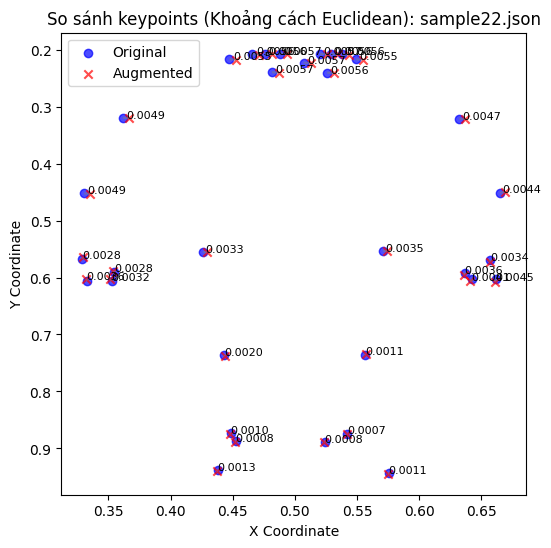


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample22.json vs data/keypoints_augmented_rotation/Garland_Pose\sample22.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00559         0.00089         0.00566
left_eye_inner       0.00560         0.00077         0.00565
left_eye             0.00558         0.00075         0.00564
left_eye_outer       0.00557         0.00077         0.00562
right_eye_inner      0.00560         0.00080         0.00566
right_eye            0.00559         0.00079         0.00565
right_eye_outer      0.00558         0.00078         0.00564
left_ear             0.00543         0.00074         0.00548
right_ear            0.00544         0.00066         0.00548
mouth_left           0.00557         0.00090         0.00564
mouth_right          0.00560         0.00079         0.00565
left_shoulder        0.00469         0.00072         0.00475
right_shoulder     

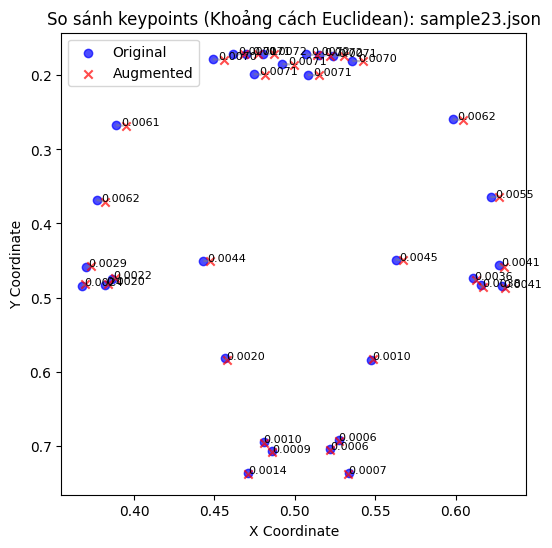


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample23.json vs data/keypoints_augmented_rotation/Garland_Pose\sample23.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00708         0.00082         0.00712
left_eye_inner       0.00712         0.00077         0.00717
left_eye             0.00711         0.00077         0.00715
left_eye_outer       0.00709         0.00084         0.00714
right_eye_inner      0.00711         0.00085         0.00716
right_eye            0.00710         0.00079         0.00715
right_eye_outer      0.00710         0.00079         0.00714
left_ear             0.00695         0.00083         0.00700
right_ear            0.00697         0.00074         0.00701
mouth_left           0.00704         0.00084         0.00709
mouth_right          0.00705         0.00080         0.00710
left_shoulder        0.00610         0.00096         0.00618
right_shoulder     

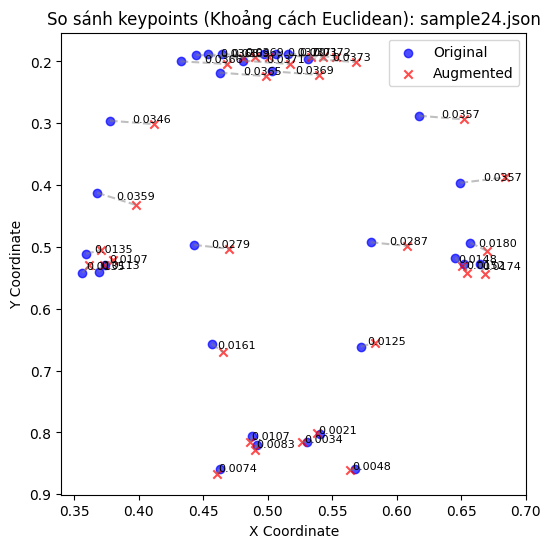


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample24.json vs data/keypoints_augmented_rotation/Garland_Pose\sample24.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.03672         0.00559         0.03715
left_eye_inner       0.03661         0.00551         0.03702
left_eye             0.03670         0.00526         0.03708
left_eye_outer       0.03678         0.00542         0.03718
right_eye_inner      0.03654         0.00523         0.03691
right_eye            0.03652         0.00494         0.03685
right_eye_outer      0.03651         0.00479         0.03682
left_ear             0.03692         0.00557         0.03734
right_ear            0.03637         0.00429         0.03662
mouth_left           0.03646         0.00584         0.03692
mouth_right          0.03604         0.00565         0.03648
left_shoulder        0.03515         0.00602         0.03566
right_shoulder     

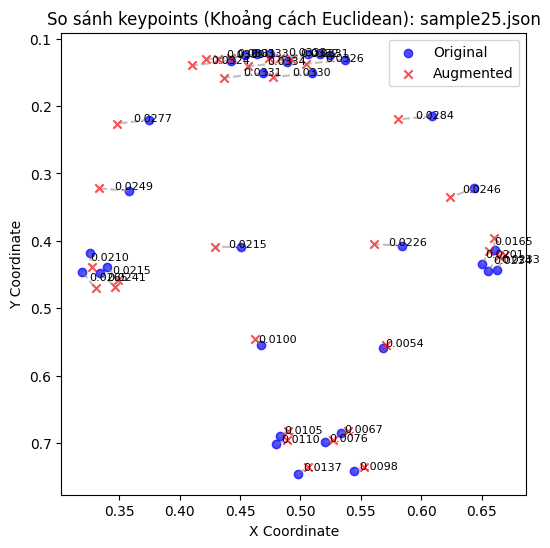


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample25.json vs data/keypoints_augmented_rotation/Garland_Pose\sample25.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.03283         0.00625         0.03342
left_eye_inner       0.03275         0.00596         0.03329
left_eye             0.03264         0.00593         0.03318
left_eye_outer       0.03252         0.00602         0.03308
right_eye_inner      0.03266         0.00629         0.03326
right_eye            0.03250         0.00638         0.03312
right_eye_outer      0.03232         0.00665         0.03300
left_ear             0.03195         0.00633         0.03257
right_ear            0.03167         0.00681         0.03240
mouth_left           0.03259         0.00545         0.03304
mouth_right          0.03242         0.00687         0.03314
left_shoulder        0.02802         0.00440         0.02837
right_shoulder     

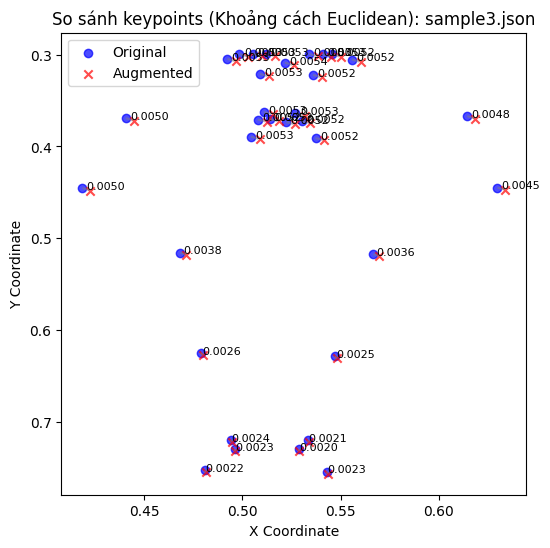


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample3.json vs data/keypoints_augmented_rotation/Garland_Pose\sample3.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00455         0.00282         0.00535
left_eye_inner       0.00446         0.00285         0.00529
left_eye             0.00445         0.00285         0.00528
left_eye_outer       0.00445         0.00277         0.00524
right_eye_inner      0.00449         0.00288         0.00534
right_eye            0.00450         0.00289         0.00535
right_eye_outer      0.00451         0.00284         0.00533
left_ear             0.00436         0.00276         0.00516
right_ear            0.00444         0.00289         0.00530
mouth_left           0.00443         0.00278         0.00523
mouth_right          0.00451         0.00277         0.00530
left_shoulder        0.00398         0.00261         0.00476
right_shoulder       

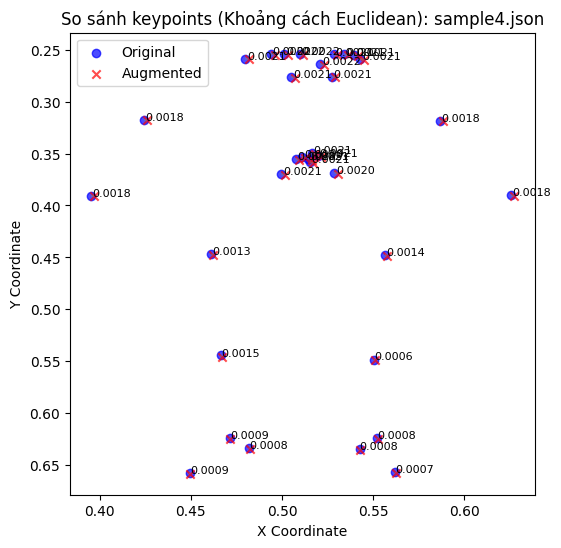


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample4.json vs data/keypoints_augmented_rotation/Garland_Pose\sample4.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00197         0.00093         0.00217
left_eye_inner       0.00197         0.00084         0.00214
left_eye             0.00197         0.00082         0.00213
left_eye_outer       0.00197         0.00083         0.00213
right_eye_inner      0.00199         0.00090         0.00218
right_eye            0.00199         0.00086         0.00217
right_eye_outer      0.00200         0.00082         0.00216
left_ear             0.00195         0.00071         0.00208
right_ear            0.00198         0.00069         0.00210
mouth_left           0.00191         0.00077         0.00206
mouth_right          0.00191         0.00084         0.00208
left_shoulder        0.00170         0.00069         0.00183
right_shoulder       

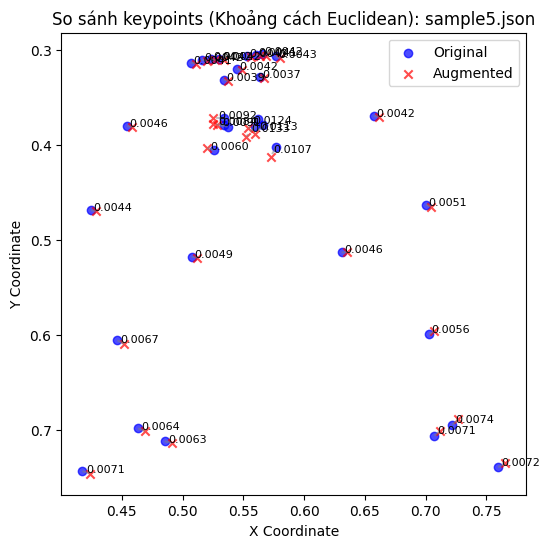


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample5.json vs data/keypoints_augmented_rotation/Garland_Pose\sample5.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00397         0.00134         0.00419
left_eye_inner       0.00386         0.00169         0.00421
left_eye             0.00378         0.00165         0.00413
left_eye_outer       0.00375         0.00191         0.00421
right_eye_inner      0.00399         0.00139         0.00423
right_eye            0.00399         0.00120         0.00417
right_eye_outer      0.00402         0.00113         0.00418
left_ear             0.00382         0.00199         0.00430
right_ear            0.00394         0.00110         0.00409
mouth_left           0.00355         0.00104         0.00370
mouth_right          0.00370         0.00117         0.00388
left_shoulder        0.00400         0.00127         0.00419
right_shoulder       

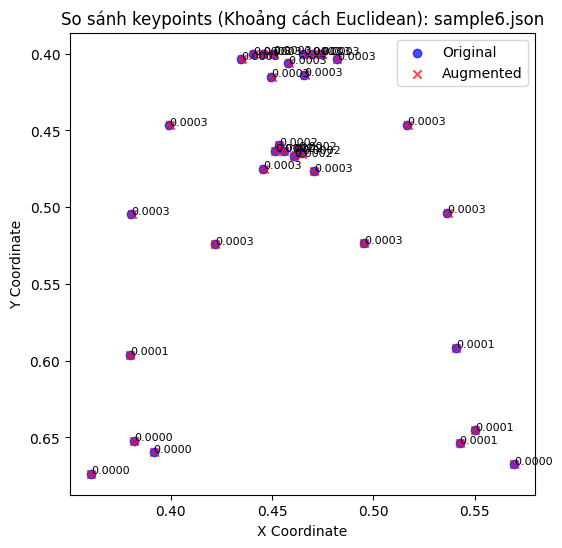


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample6.json vs data/keypoints_augmented_rotation/Garland_Pose\sample6.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00031         0.00007         0.00032
left_eye_inner       0.00031         0.00007         0.00031
left_eye             0.00031         0.00007         0.00031
left_eye_outer       0.00031         0.00007         0.00031
right_eye_inner      0.00031         0.00007         0.00032
right_eye            0.00031         0.00007         0.00032
right_eye_outer      0.00032         0.00007         0.00032
left_ear             0.00030         0.00007         0.00031
right_ear            0.00032         0.00007         0.00033
mouth_left           0.00031         0.00005         0.00031
mouth_right          0.00031         0.00007         0.00031
left_shoulder        0.00028         0.00004         0.00029
right_shoulder       

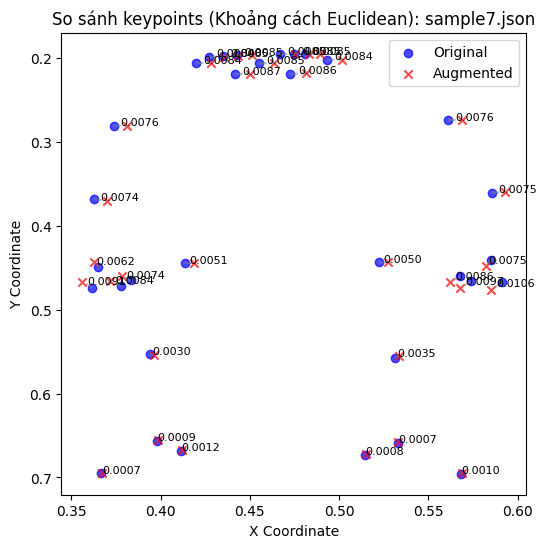


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample7.json vs data/keypoints_augmented_rotation/Garland_Pose\sample7.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00846         0.00058         0.00848
left_eye_inner       0.00853         0.00039         0.00854
left_eye             0.00852         0.00028         0.00853
left_eye_outer       0.00851         0.00037         0.00852
right_eye_inner      0.00849         0.00043         0.00850
right_eye            0.00845         0.00031         0.00846
right_eye_outer      0.00842         0.00030         0.00843
left_ear             0.00840         0.00027         0.00840
right_ear            0.00838         0.00012         0.00838
mouth_left           0.00855         0.00029         0.00856
mouth_right          0.00864         0.00058         0.00866
left_shoulder        0.00755         0.00034         0.00756
right_shoulder       

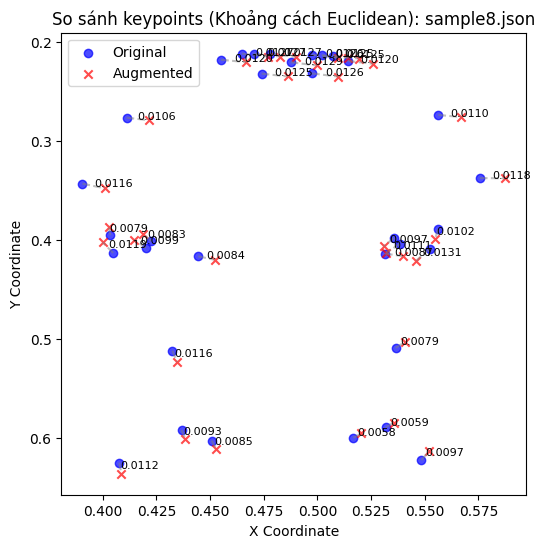


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample8.json vs data/keypoints_augmented_rotation/Garland_Pose\sample8.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.01246         0.00320         0.01287
left_eye_inner       0.01224         0.00319         0.01265
left_eye             0.01218         0.00295         0.01253
left_eye_outer       0.01209         0.00298         0.01246
right_eye_inner      0.01235         0.00303         0.01272
right_eye            0.01235         0.00283         0.01267
right_eye_outer      0.01234         0.00284         0.01266
left_ear             0.01170         0.00284         0.01204
right_ear            0.01180         0.00237         0.01204
mouth_left           0.01220         0.00318         0.01261
mouth_right          0.01222         0.00285         0.01255
left_shoulder        0.01075         0.00213         0.01096
right_shoulder       

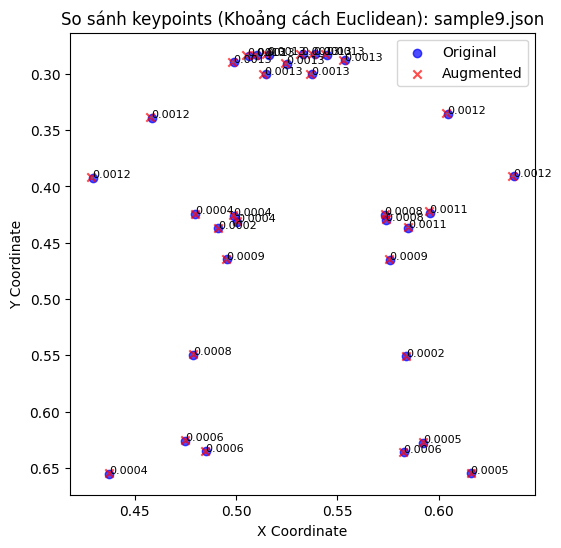


 Sự khác biệt giữa data/keypoints/Garland_Pose\sample9.json vs data/keypoints_augmented_rotation/Garland_Pose\sample9.json
Keypoint             X Diff          Y Diff          Distance
------------------------------------------------------------
nose                 0.00127         0.00039         0.00133
left_eye_inner       0.00127         0.00040         0.00134
left_eye             0.00127         0.00042         0.00134
left_eye_outer       0.00127         0.00044         0.00134
right_eye_inner      0.00127         0.00038         0.00132
right_eye            0.00126         0.00039         0.00131
right_eye_outer      0.00125         0.00041         0.00131
left_ear             0.00122         0.00051         0.00132
right_ear            0.00118         0.00045         0.00127
mouth_left           0.00126         0.00046         0.00134
mouth_right          0.00126         0.00040         0.00132
left_shoulder        0.00106         0.00059         0.00122
right_shoulder       

In [35]:
original_folder = "data/keypoints/Garland_Pose"
augmented_folder = "data/keypoints_augmented_rotation/Garland_Pose"

visualize_folder(original_folder, augmented_folder)

#### NORMALIZATION

##### Mean Centering

PHƯƠNG PHÁP MEAN CENTERING NORMALIZATION
- Tính trung bình của tất cả keypoints trong toàn bộ video trên tọa độ x và y.
- Dịch tất cả keypoints về trung tâm (0,0) bằng cách trừ đi trung bình này.

Mục đích: 
- Giúp mô hình không bị ảnh hưởng bởi vị trí tuyệt đối của đối tượng.
    * Nếu người thực hiện động tác đứng lệch trái/phải trong video, tọa độ tuyệt đối sẽ khác, nhưng động tác vẫn giống nhau.
    * Normalize giúp mô hình chỉ tập trung vào hình dạng động tác, không phải vị trí. 
- Tạo sự đồng nhất giữa các video
    * Nếu video 1 có người ở góc trên bên phải, video 2 có người ở trung tâm, thì mô hình có thể gặp khó khăn khi học.
    * Normalize giúp đồng nhất dữ liệu, làm cho mô hình dễ học hơn. 
- Loại bỏ ảnh hưởng của vị trí camera
    * Nếu camera đặt ở nhiều góc khác nhau, tọa độ keypoints có thể lệch nhưng động tác vẫn giống nhau.
    * Chuẩn hóa giúp mô hình không phụ thuộc vào góc nhìn camera.     

In [ ]:
"""
input shape: (num_frames, num_keypoints, 3) --> (T, 33, 3)
    - T: số lượng frame
    - 33: số lượng keypoints
    - 3: tọa độ x, y, z của keypoints
Công thức toán học: 
    - mean(x) = 1/T*33 * sum(t=1->T, sum(i=1->33, x_t,i))
    - mean(y) = 1/T*33 * sum(t=1->T, sum(i=1->33, y_t,i))
    - skeletion(t,i,x) = x_t,i - mean(x)
    - skeletion(t,i,y) = y_t,i - mean(y)
    --> Mỗi keypoint (x, y) được trừ đi trung bình của toàn bộ keypoints
"""

def normalize_skeleton(skeleton):
    """Chuẩn hóa skeleton về trung tâm bằng cách trừ đi tọa độ trung bình."""
    mean_pose = np.mean(skeleton[:, :, :2], axis=(0, 1))  # Trung bình trên trục x, y
    skeleton[:, :, :2] -= mean_pose  # Dịch keypoints về trung tâm
    return skeleton

##### Min-Max Normalization

PHƯƠNG PHÁP MIN-MAX NORMALIZATION:
- Scale tọa độ (x, y, z) của keypoints về khoảng [0, 1].
- Giữ nguyên tỷ lệ tương đối của các điểm

ƯU ĐIỂM:
- Giữ nguyên tỷ lệ giữa các điểm.
- Dễ dàng áp dụng trên nhiều bộ dữ liệu khác nhau.

NHƯỢC ĐIỂM
- Dễ bị ảnh hưởng bởi outlier

In [ ]:
"""
Công thức: 
    x' = (x - min_x) / (max_x - min_x)
    y' = (y - min_y) / (max_y - min_y)
"""
def min_max_normalization(skeleton):
    """Chuẩn hóa tọa độ skeleton về khoảng [0,1] theo Min-Max Scaling."""
    min_vals = np.min(skeleton[:, :, :2], axis=(0, 1))  # (x_min, y_min)
    max_vals = np.max(skeleton[:, :, :2], axis=(0, 1))  # (x_max, y_max)
    
    skeleton[:, :, :2] = (skeleton[:, :, :2] - min_vals) / (max_vals - min_vals + 1e-6)  # Tránh chia cho 0
    return skeleton

##### Z-Score Normalization

PHƯƠNG PHÁP Z-SCORE NORMALIZATION:
- Chuẩn hóa tọa độ (x, y, z) bằng cách chuyển về phân phối chuẩn (mean = 0, std = 1).

ƯU ĐIỂM:
- Ổn định hơn Min-Max Normalization khi có outliers.
- Giữ lại thông tin phân phối dữ liệu.

NHƯỢC ĐIỂM:
- Nếu dữ liệu không tuân theo phân phối chuẩn thì có thể làm mất thông tin.

In [ ]:
"""
Công thức:
    x' = (x - mean_x) / std_x
    y' = (y - mean_y) / std_y
"""
def z_score_normalization(skeleton):
    """Chuẩn hóa tọa độ skeleton về phân phối chuẩn (mean=0, std=1)."""
    mean_vals = np.mean(skeleton[:, :, :2], axis=(0, 1))  # Mean của (x, y)
    std_vals = np.std(skeleton[:, :, :2], axis=(0, 1))  # Standard deviation của (x, y)

    skeleton[:, :, :2] = (skeleton[:, :, :2] - mean_vals) / (std_vals + 1e-6)  # Tránh chia cho 0
    return skeleton

##### BONE LENGTH NORMALIZATION

PHƯƠNG PHÁP BONE LENGTH NORMALIZATION:
- Thay vì scale tất cả điểm keypoints theo toàn bộ frame, ta scale dựa trên chiều dài xương cơ thể.
- Ví dụ: Scale tất cả điểm theo khoảng cách giữa hai vai.

ƯU ĐIỂM:
- Giúp mô hình không bị ảnh hưởng bởi chiều cao người tập.
- Ổn định hơn khi áp dụng cho nhiều người khác nhau.

NHƯỢC ĐIỂM:
- Phụ thuộc vào việc xác định đúng keypoints (nếu Mediapipe nhận diện lỗi, việc chuẩn hóa có thể bị ảnh hưởng).

In [ ]:
def bone_length_normalization(skeleton):
    """Chuẩn hóa skeleton dựa trên khoảng cách giữa hai vai."""
    left_shoulder = skeleton[:, 11, :2]  # Keypoint 11: vai trái
    right_shoulder = skeleton[:, 12, :2]  # Keypoint 12: vai phải

    # Tính khoảng cách giữa hai vai
    shoulder_distance = np.linalg.norm(left_shoulder - right_shoulder, axis=1, keepdims=True)

    # Scale toàn bộ tọa độ dựa trên khoảng cách này
    skeleton[:, :, :2] /= (shoulder_distance[:, None] + 1e-6)  # Tránh chia cho 0
    return skeleton

##### FRAME NORMALIZATION

PHƯƠNG PHÁP FRAME NORMALIZATION:
- Chuẩn hóa mỗi frame riêng biệt, thay vì tính toán trên toàn bộ video.
- Cách này giúp dữ liệu được cân đối frame-by-frame.

ƯU ĐIỂM:
- Không bị ảnh hưởng bởi độ dài video.
- Cực kỳ hiệu quả khi video có nhiều sự thay đổi động tác.

NHƯỢC ĐIỂM:
- Mất đi vị trí tuyệt đối của khung hình, chỉ giữ lại thông tin về mối quan hệ giữa keypoints.

In [ ]:
def frame_wise_normalization(skeleton):
    """Chuẩn hóa từng frame riêng biệt bằng cách dịch tọa độ về trung tâm frame đó."""
    for t in range(skeleton.shape[0]):  # Duyệt từng frame
        mean_pose = np.mean(skeleton[t, :, :2], axis=0)  # Trung bình (x, y) của frame t
        skeleton[t, :, :2] -= mean_pose  # Trừ đi giá trị trung bình frame
    return skeleton

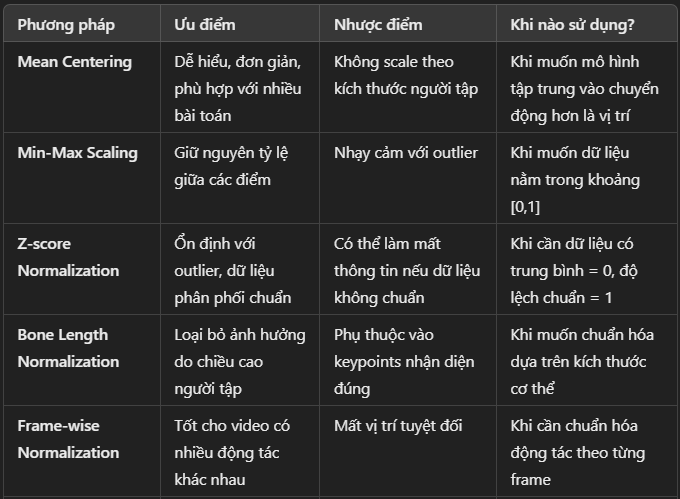